In [1]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Number of GPU:  1
GPU Name:  NVIDIA GeForce RTX 3070 Laptop GPU
Using device: cuda


In [2]:
import os
from torch.utils.data import Dataset
from PIL import Image
import numpy as np
import pandas as pd
import torch

In [3]:
csv_path = r"D:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\Data\Train_test\Counts_BB.csv"
df = pd.read_csv(csv_path)

# Strip any extra spaces from column names, if needed
df.columns = df.columns.str.strip()

image_dir = r"D:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\Data\Train_test"

In [4]:
df.head()

,Unnamed: 0,frame_name,sperm_count,cluster_count,small_or_pinhead_count,folder,fid,class,bb0,bb1,bb2,bb3
0,0,14_frame_0,3,0,0,14,ckyw6zzlj001r3867thf0fuy7,0,0.208594,0.825000,0.035937,0.037500
1,1,14_frame_0,3,0,0,14,ckyw704kw001v3867kvyjtx6k,0,0.796094,0.797917,0.029687,0.037500
2,2,14_frame_0,3,0,0,14,ckyw708pn001z386779fr849h,0,0.827344,0.123958,0.035937,0.039583
3,3,14_frame_1,3,0,0,14,ckyw6zzlj001r3867thf0fuy7,0,0.208594,0.814583,0.035937,0.037500
4,4,14_frame_1,3,0,0,14,ckyw704kw001v3867kvyjtx6k,0,0.764062,0.781250,0.029687,0.037500


In [4]:
# Define image dimensions
image_width = 640
image_height = 480

# Convert YOLOv8-style normalized boxes to absolute pixel coordinates
df["x_center"] = df["bb0"] * image_width
df["y_center"] = df["bb1"] * image_height
df["box_width"] = df["bb2"] * image_width
df["box_height"] = df["bb3"] * image_height

# Calculate corners from center format
df["xmin"] = df["x_center"] - (df["box_width"] / 2)
df["ymin"] = df["y_center"] - (df["box_height"] / 2)
df["xmax"] = df["x_center"] + (df["box_width"] / 2)
df["ymax"] = df["y_center"] + (df["box_height"] / 2)


In [5]:
df = df.drop(columns=["x_center", "y_center", "box_width", "box_height"])


In [7]:
df

,Unnamed: 0,frame_name,sperm_count,cluster_count,small_or_pinhead_count,folder,fid,class,bb0,bb1,bb2,bb3,xmin,ymin,xmax,ymax
0,0,14_frame_0,3,0,0,14,ckyw6zzlj001r3867thf0fuy7,0,0.208594,0.825000,0.035937,0.037500,122.0,387.0,145.0,405.0
1,1,14_frame_0,3,0,0,14,ckyw704kw001v3867kvyjtx6k,0,0.796094,0.797917,0.029687,0.037500,500.0,374.0,519.0,392.0
2,2,14_frame_0,3,0,0,14,ckyw708pn001z386779fr849h,0,0.827344,0.123958,0.035937,0.039583,518.0,50.0,541.0,69.0
3,3,14_frame_1,3,0,0,14,ckyw6zzlj001r3867thf0fuy7,0,0.208594,0.814583,0.035937,0.037500,122.0,382.0,145.0,400.0
4,4,14_frame_1,3,0,0,14,ckyw704kw001v3867kvyjtx6k,0,0.764062,0.781250,0.029687,0.037500,479.5,366.0,498.5,384.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19836,19836,52_frame_427,6,0,2,52,cl1x89ze6000o3f6baic4zklo,0,0.464062,0.462500,0.037500,0.054167,285.0,209.0,309.0,235.0
19837,19837,52_frame_427,6,0,2,52,cl1x8a7j3000s3f6bvn1rm1tw,0,0.416406,0.400000,0.029687,0.045833,257.0,181.0,276.0,203.0
19838,19838,52_frame_427,6,0,2,52,cl1x8ih7n00103f6b67egfbw2,0,0.057031,0.803125,0.032813,0.043750,26.0,375.0,47.0,396.0
19839,19839,52_frame_427,6,0,2,52,cl52g254u000o3b6gcyhoi1fk,2,0.132031,0.112500,0.026562,0.037500,76.0,45.0,93.0,63.0


In [6]:
class SpermDetectionDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.image_ids = dataframe['frame_name'].unique()
        self.img_width = 640
        self.img_height = 480

    def __getitem__(self, index):
        image_id = self.image_ids[index]
        image_path = os.path.join(self.image_dir, image_id + ".jpg")

        # Load grayscale image and convert to 1-channel tensor
        image = Image.open(image_path).convert("L")
        

        # Filter bounding boxes for this image
        records = self.df[self.df["frame_name"] == image_id]
        boxes = []

        for _, row in records.iterrows():
            xmin = row["xmin"]
            ymin = row["ymin"]
            xmax = row["xmax"]
            ymax = row["ymax"]
            boxes.append([xmin, ymin, xmax, ymax])


        # Handle images with no sperm (i.e., no boxes)
        if len(boxes) == 0:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            labels = torch.zeros((0,), dtype=torch.int64)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            labels = torch.ones((boxes.shape[0],), dtype=torch.int64)  # class 1 for sperm

        target = {
            "boxes": boxes,
            "labels": labels,
            "image_id": torch.tensor([index])
        }

        if self.transforms:
            image = self.transforms(image)

        return image, target

    def __len__(self):
        return len(self.image_ids)

In [7]:
from sklearn.model_selection import train_test_split

# Split on frame_name to avoid splitting boxes from the same image
unique_frames = df['frame_name'].unique()
train_ids, val_ids = train_test_split(unique_frames, test_size=0.2, random_state=42)

train_df = df[df['frame_name'].isin(train_ids)]
val_df = df[df['frame_name'].isin(val_ids)]


In [8]:
import torchvision.transforms as T

train_transforms = T.Compose([
    T.ToTensor(),  # Converts grayscale image to [1, H, W]
    T.Lambda(lambda x: x.repeat(3, 1, 1)),  # Replicates to [3, H, W]
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Full ImageNet normalization
])

# Pass to dataset
train_dataset = SpermDetectionDataset(train_df, image_dir=image_dir, transforms=train_transforms)
val_dataset = SpermDetectionDataset(val_df, image_dir=image_dir, transforms=train_transforms)



In [9]:
img, target = train_dataset[0]
print(img.shape)  # should be torch.Size([3, 480, 640])

torch.Size([3, 480, 640])


In [9]:
from torch.utils.data import DataLoader

# Custom collate function for object detection
def collate_fn(batch):
    return tuple(zip(*batch))

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)

val_loader = DataLoader(
    val_dataset,
    batch_size=2,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)


In [11]:
img, target = train_dataset[0]
print(img.shape, target)


torch.Size([3, 480, 640]) {'boxes': tensor([[122., 387., 145., 405.],
        [500., 374., 519., 392.],
        [518.,  50., 541.,  69.]]), 'labels': tensor([1, 1, 1]), 'image_id': tensor([0])}


In [10]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models import resnet50
from torchvision.models.detection.rpn import AnchorGenerator
import torch.nn as nn

In [11]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect()  # Optional: releases unused cached memory

In [11]:
def build_model(num_classes=2, anchor_sizes=((16, 32, 64, 128, 256),), aspect_ratios=((0.5, 1.0, 2.0),) * 5, box_nms_thresh=0.5):
    backbone = resnet50(pretrained=True)
    backbone = nn.Sequential(*list(backbone.children())[:-2])
    backbone.out_channels = 2048

    anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

    model = FasterRCNN(
        backbone,
        num_classes=num_classes,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        box_nms_thresh=box_nms_thresh
    )

    return model


In [17]:
import itertools
import random

search_space = {
    "lr": [1e-3, 1e-4, 1e-5],
    "weight_decay": [0, 0.0001, 0.0005],
    "step_size": [3, 5],
    "gamma": [0.1, 0.2],
    "anchor_sizes": [((8, 16, 32, 64),), ((16, 32, 64, 128, 256),)],
    "aspect_ratios": [((0.5, 1.0, 2.0),) * 5, ((0.5, 1.0, 1.5, 2.0),) * 5],
    "box_nms_thresh": [0.3, 0.5, 0.7],
    "score_thresh": [0.4, 0.5, 0.6]
}

keys, values = zip(*search_space.items())
all_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]
random.seed(42)
sampled_combinations = random.sample(all_combinations, 20)  

In [11]:
from tqdm import tqdm
import time

In [13]:
def validate(model, val_loader, df, device, score_thresh=0.5):
    model.eval()
    total_images = 0
    total_abs_error = 0
    all_true_counts = []
    all_pred_counts = []

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Validating"):

            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                frame_id = targets[i]['image_id'].item()
                frame_name = val_dataset.image_ids[frame_id]

                scores = output['scores'].cpu()
                pred_count = (scores > score_thresh).sum().item()

                true_count = df[df['frame_name'] == frame_name]['sperm_count'].iloc[0]

                total_abs_error += abs(true_count - pred_count)
                all_true_counts.append(true_count)
                all_pred_counts.append(pred_count)
                total_images += 1

    mae = total_abs_error / total_images
    print(f"🔍 Validation: Mean Absolute Count Error = {mae:.2f}")
    return mae

In [12]:
from torchvision.ops import box_iou

def validate_iou(model, val_loader, df, device, score_thresh=0.5):
    model.eval()
    total_iou = 0
    total_pairs = 0
    iou_list = []

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Validating (IoU)"):
            torch.cuda.empty_cache()
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                frame_id = targets[i]['image_id'].item()
                frame_name = val_dataset.image_ids[frame_id]

                scores = output['scores'].cpu()
                boxes_pred = output['boxes'][scores > score_thresh].cpu()
                
                # Get ground truth boxes
                gt_boxes = df[df['frame_name'] == frame_name][['xmin', 'ymin', 'xmax', 'ymax']].values
                boxes_true = torch.tensor(gt_boxes, dtype=torch.float32)

                if len(boxes_pred) == 0 or len(boxes_true) == 0:
                    continue  # Skip if no predictions or ground truth

                # Compute IoU matrix between predicted and true boxes
                ious = box_iou(boxes_pred, boxes_true)

                # Greedy matching: for each predicted box, take best matching GT box
                max_ious, _ = ious.max(dim=1)
                total_iou += max_ious.sum().item()
                total_pairs += len(max_ious)
                iou_list.extend(max_ious.tolist())

    mean_iou = total_iou / total_pairs if total_pairs > 0 else 0
    print(f"📏 Validation: Mean IoU = {mean_iou:.4f}")
    return mean_iou

In [16]:
iou_per_epoch = []

In [17]:
def random_search(train_dataset, val_dataset, param_grid, device, df, num_epochs=2):
    results = []

    for i, config in enumerate(param_grid):
        print(f"\n🔁 Running config {i+1}/{len(param_grid)}: {config}")
        model = build_model(
            anchor_sizes=config["anchor_sizes"],
            aspect_ratios=config["aspect_ratios"],
            box_nms_thresh=config["box_nms_thresh"]
        ).to(device)
        model.train()

        # train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=0)
        # val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn, num_workers=0)

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.Adam(params, lr=config["lr"], weight_decay=config["weight_decay"])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config["step_size"], gamma=config["gamma"])

        for epoch in range(num_epochs):
            epoch_loss = 0.0
            print(f"🧪 Config {i+1}/{len(param_grid)} | Epoch {epoch+1}/{num_epochs}")
            start_epoch = time.time()

            for images, targets in tqdm(train_loader, desc=f"Training (Config {i+1})", leave=False):
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                try:
                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())

                    optimizer.zero_grad()
                    losses.backward()
                    optimizer.step()

                    epoch_loss += losses.item()
                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print("[OOM ERROR] Skipping batch")
                        torch.cuda.empty_cache()
                        continue

            scheduler.step()

            duration = time.time() - start_epoch
            print(f"✅ Epoch {epoch+1}/{num_epochs} done in {duration:.1f}s | Avg Loss: {epoch_loss/len(train_loader):.4f}")

        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()  # optional cleanup
        val_iou = validate_iou(model, val_loader, df, device, score_thresh=config["score_thresh"])
        config_result = config.copy()
        config_result["mean_iou"] = val_iou
        results.append(config_result)

    results_df = pd.DataFrame(results)
    best_config = results_df.loc[results_df["mean_iou"].idxmax()]
    print(f"\n🏆 Best Hyperparameters:\n{best_config}")
    return results_df, best_config


In [23]:
results_df, best_config = random_search(train_dataset, val_dataset, sampled_combinations, device, df)



🔁 Running config 1/20: {'lr': 0.001, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.1, 'anchor_sizes': ((8, 16, 32, 64),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.4}


d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🧪 Config 1/20 | Epoch 1/2


✅ Epoch 1/2 done in 1095.1s | Avg Loss: 0.1240
🧪 Config 1/20 | Epoch 2/2


✅ Epoch 2/2 done in 1026.7s | Avg Loss: 0.0926


Validating (IoU): 100%|██████████| 555/555 [02:13<00:00,  4.17it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6111

🔁 Running config 2/20: {'lr': 0.001, 'weight_decay': 0, 'step_size': 3, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.7, 'score_thresh': 0.4}
🧪 Config 2/20 | Epoch 1/2


✅ Epoch 1/2 done in 1008.3s | Avg Loss: 0.1552
🧪 Config 2/20 | Epoch 2/2


✅ Epoch 2/2 done in 1100.6s | Avg Loss: 0.0903


Validating (IoU): 100%|██████████| 555/555 [02:15<00:00,  4.10it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.4693

🔁 Running config 3/20: {'lr': 0.0001, 'weight_decay': 0, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
🧪 Config 3/20 | Epoch 1/2


✅ Epoch 1/2 done in 1028.5s | Avg Loss: 0.0872
🧪 Config 3/20 | Epoch 2/2


✅ Epoch 2/2 done in 1008.4s | Avg Loss: 0.0577


Validating (IoU): 100%|██████████| 555/555 [02:05<00:00,  4.41it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6949

🔁 Running config 4/20: {'lr': 0.0001, 'weight_decay': 0, 'step_size': 3, 'gamma': 0.2, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.7, 'score_thresh': 0.4}
🧪 Config 4/20 | Epoch 1/2


✅ Epoch 1/2 done in 1007.2s | Avg Loss: 0.0971
🧪 Config 4/20 | Epoch 2/2


✅ Epoch 2/2 done in 1001.5s | Avg Loss: 0.0648


Validating (IoU): 100%|██████████| 555/555 [02:08<00:00,  4.32it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6092

🔁 Running config 5/20: {'lr': 0.0001, 'weight_decay': 0, 'step_size': 3, 'gamma': 0.1, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.7, 'score_thresh': 0.5}
🧪 Config 5/20 | Epoch 1/2


✅ Epoch 1/2 done in 1067.4s | Avg Loss: 0.0873
🧪 Config 5/20 | Epoch 2/2


✅ Epoch 2/2 done in 1082.3s | Avg Loss: 0.0578


Validating (IoU): 100%|██████████| 555/555 [02:18<00:00,  4.00it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6251

🔁 Running config 6/20: {'lr': 0.001, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.7, 'score_thresh': 0.4}
🧪 Config 6/20 | Epoch 1/2


✅ Epoch 1/2 done in 1006.5s | Avg Loss: 0.1279
🧪 Config 6/20 | Epoch 2/2


✅ Epoch 2/2 done in 992.3s | Avg Loss: 0.0882


Validating (IoU): 100%|██████████| 555/555 [02:03<00:00,  4.49it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6294

🔁 Running config 7/20: {'lr': 0.001, 'weight_decay': 0.0001, 'step_size': 3, 'gamma': 0.2, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.3, 'score_thresh': 0.6}
🧪 Config 7/20 | Epoch 1/2


✅ Epoch 1/2 done in 997.0s | Avg Loss: 0.1537
🧪 Config 7/20 | Epoch 2/2


✅ Epoch 2/2 done in 989.0s | Avg Loss: 0.0967


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.62it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6513

🔁 Running config 8/20: {'lr': 1e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.3, 'score_thresh': 0.4}
🧪 Config 8/20 | Epoch 1/2


✅ Epoch 1/2 done in 1020.2s | Avg Loss: 0.0946
🧪 Config 8/20 | Epoch 2/2


✅ Epoch 2/2 done in 1015.5s | Avg Loss: 0.0654


Validating (IoU): 100%|██████████| 555/555 [02:15<00:00,  4.08it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6053

🔁 Running config 9/20: {'lr': 0.001, 'weight_decay': 0.0001, 'step_size': 3, 'gamma': 0.1, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.7, 'score_thresh': 0.5}
🧪 Config 9/20 | Epoch 1/2


✅ Epoch 1/2 done in 998.0s | Avg Loss: 0.1290
🧪 Config 9/20 | Epoch 2/2


✅ Epoch 2/2 done in 986.7s | Avg Loss: 0.0929


Validating (IoU): 100%|██████████| 555/555 [01:55<00:00,  4.80it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.5139

🔁 Running config 10/20: {'lr': 1e-05, 'weight_decay': 0.0005, 'step_size': 3, 'gamma': 0.2, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.4}
🧪 Config 10/20 | Epoch 1/2


✅ Epoch 1/2 done in 1011.2s | Avg Loss: 0.0962
🧪 Config 10/20 | Epoch 2/2


✅ Epoch 2/2 done in 1009.4s | Avg Loss: 0.0661


Validating (IoU): 100%|██████████| 555/555 [02:08<00:00,  4.31it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6536

🔁 Running config 11/20: {'lr': 1e-05, 'weight_decay': 0, 'step_size': 3, 'gamma': 0.1, 'anchor_sizes': ((8, 16, 32, 64),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.3, 'score_thresh': 0.4}
🧪 Config 11/20 | Epoch 1/2


✅ Epoch 1/2 done in 1002.0s | Avg Loss: 0.0949
🧪 Config 11/20 | Epoch 2/2


✅ Epoch 2/2 done in 1009.6s | Avg Loss: 0.0668


Validating (IoU): 100%|██████████| 555/555 [02:14<00:00,  4.12it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.4746

🔁 Running config 12/20: {'lr': 0.001, 'weight_decay': 0, 'step_size': 3, 'gamma': 0.2, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.3, 'score_thresh': 0.6}
🧪 Config 12/20 | Epoch 1/2


✅ Epoch 1/2 done in 982.0s | Avg Loss: 0.1422
🧪 Config 12/20 | Epoch 2/2


✅ Epoch 2/2 done in 975.2s | Avg Loss: 0.1092


Validating (IoU): 100%|██████████| 555/555 [02:09<00:00,  4.29it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6793

🔁 Running config 13/20: {'lr': 0.001, 'weight_decay': 0, 'step_size': 3, 'gamma': 0.2, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.7, 'score_thresh': 0.5}
🧪 Config 13/20 | Epoch 1/2


✅ Epoch 1/2 done in 977.9s | Avg Loss: 0.1472
🧪 Config 13/20 | Epoch 2/2


✅ Epoch 2/2 done in 977.2s | Avg Loss: 0.0884


Validating (IoU): 100%|██████████| 555/555 [02:10<00:00,  4.25it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6025

🔁 Running config 14/20: {'lr': 0.001, 'weight_decay': 0.0001, 'step_size': 3, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.3, 'score_thresh': 0.6}
🧪 Config 14/20 | Epoch 1/2


✅ Epoch 1/2 done in 1000.6s | Avg Loss: 0.1334
🧪 Config 14/20 | Epoch 2/2


✅ Epoch 2/2 done in 995.2s | Avg Loss: 0.0912


Validating (IoU): 100%|██████████| 555/555 [01:49<00:00,  5.08it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6373

🔁 Running config 15/20: {'lr': 0.0001, 'weight_decay': 0, 'step_size': 3, 'gamma': 0.1, 'anchor_sizes': ((8, 16, 32, 64),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.7, 'score_thresh': 0.4}
🧪 Config 15/20 | Epoch 1/2


✅ Epoch 1/2 done in 996.0s | Avg Loss: 0.0995
🧪 Config 15/20 | Epoch 2/2


✅ Epoch 2/2 done in 995.5s | Avg Loss: 0.0677


Validating (IoU): 100%|██████████| 555/555 [02:11<00:00,  4.21it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.5039

🔁 Running config 16/20: {'lr': 0.0001, 'weight_decay': 0, 'step_size': 3, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.7, 'score_thresh': 0.6}
🧪 Config 16/20 | Epoch 1/2


✅ Epoch 1/2 done in 997.6s | Avg Loss: 0.0869
🧪 Config 16/20 | Epoch 2/2


✅ Epoch 2/2 done in 991.3s | Avg Loss: 0.0597


Validating (IoU): 100%|██████████| 555/555 [02:11<00:00,  4.24it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.5806

🔁 Running config 17/20: {'lr': 1e-05, 'weight_decay': 0.0001, 'step_size': 3, 'gamma': 0.1, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.7, 'score_thresh': 0.6}
🧪 Config 17/20 | Epoch 1/2


✅ Epoch 1/2 done in 1005.4s | Avg Loss: 0.0981
🧪 Config 17/20 | Epoch 2/2


✅ Epoch 2/2 done in 1007.1s | Avg Loss: 0.0677


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.72it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6555

🔁 Running config 18/20: {'lr': 1e-05, 'weight_decay': 0.0005, 'step_size': 5, 'gamma': 0.1, 'anchor_sizes': ((8, 16, 32, 64),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.7, 'score_thresh': 0.6}
🧪 Config 18/20 | Epoch 1/2


✅ Epoch 1/2 done in 1016.7s | Avg Loss: 0.0934
🧪 Config 18/20 | Epoch 2/2


✅ Epoch 2/2 done in 1017.9s | Avg Loss: 0.0645


Validating (IoU): 100%|██████████| 555/555 [02:18<00:00,  4.02it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6535

🔁 Running config 19/20: {'lr': 0.001, 'weight_decay': 0, 'step_size': 3, 'gamma': 0.2, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.3, 'score_thresh': 0.4}
🧪 Config 19/20 | Epoch 1/2


✅ Epoch 1/2 done in 999.6s | Avg Loss: 0.1057
🧪 Config 19/20 | Epoch 2/2


✅ Epoch 2/2 done in 992.6s | Avg Loss: 0.1118


Validating (IoU): 100%|██████████| 555/555 [01:55<00:00,  4.81it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.4953

🔁 Running config 20/20: {'lr': 1e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.7, 'score_thresh': 0.4}
🧪 Config 20/20 | Epoch 1/2


✅ Epoch 1/2 done in 1034.8s | Avg Loss: 0.1119
🧪 Config 20/20 | Epoch 2/2


✅ Epoch 2/2 done in 1044.0s | Avg Loss: 0.0780


Validating (IoU): 100%|██████████| 555/555 [02:14<00:00,  4.12it/s]

📏 Validation: Mean IoU = 0.5903

🏆 Best Hyperparameters:
lr                                                           0.0001
weight_decay                                                    0.0
step_size                                                         5
gamma                                                           0.2
anchor_sizes                              ((16, 32, 64, 128, 256),)
aspect_ratios     ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, ...
box_nms_thresh                                                  0.5
score_thresh                                                    0.6
mean_iou                                                   0.694898
Name: 2, dtype: object


In [ ]:
# # Use best_config from random search
# final_model = build_model().to(device)
# final_model.train()

# train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn, num_workers=0)

# params = [p for p in final_model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params, lr=best_config["lr"], weight_decay=best_config["weight_decay"])
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=best_config["step_size"], gamma=best_config["gamma"])


d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# # Load pretrained ResNet-152
# backbone = resnet152(pretrained=True)

# # Remove the avgpool and fc layers (keep feature extractor)
# backbone = nn.Sequential(*list(backbone.children())[:-2])
# backbone.out_channels = 2048  # Output channels from ResNet-152



In [26]:
# # Define anchor sizes and aspect ratios (good for small sperm objects)
# anchor_generator = AnchorGenerator(
#     sizes=((16, 32, 64, 128, 256),),
#     aspect_ratios=((0.5, 1.0, 2.0),) * 5
# )

In [27]:
# # ROI pooling layer (extracts fixed-size features from proposals)
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=['0'],
#     output_size=7,
#     sampling_ratio=2
# )

In [28]:
# # Build Faster R-CNN model
# model = FasterRCNN(
#     backbone,
#     num_classes=2,  # 1 for sperm + 1 for background
#     rpn_anchor_generator=anchor_generator,
#     box_roi_pool=roi_pooler
# )

# # Move model to GPU
# model.to(device)

In [29]:
# # Only update trainable parameters
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.Adam(params, lr=0.0001, weight_decay=0.0005)

In [ ]:
# best_val_mae = float('inf')  # Track best validation performance


In [24]:
torch.cuda.empty_cache()
torch.cuda.ipc_collect() 

In [18]:
import itertools
import random

search_space_fine = {
    "lr": [5e-5, 1e-4, 2e-4],
    "weight_decay": [0.0, 0.00001, 0.0001],
    "step_size": [4, 5, 6],
    "gamma": [0.15, 0.2, 0.25],
    "anchor_sizes": [((8, 16, 32, 64, 128),), ((16, 32, 64, 128, 256),)],
    "aspect_ratios": [((0.5, 1.0, 2.0),) * 5, ((0.5, 1.0, 1.5, 2.0),) * 5],
    "box_nms_thresh": [0.4, 0.5, 0.6],
    "score_thresh": [0.5, 0.6, 0.7]
}

# Create combinations
keys, values = zip(*search_space_fine.items())
all_combinations_fine = [dict(zip(keys, v)) for v in itertools.product(*values)]

# Sample N combinations (try 15 or more)
random.seed(42)
sampled_combinations_fine = random.sample(all_combinations_fine, 20)


In [19]:
results_df_fine, best_config_fine = random_search(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    param_grid=sampled_combinations_fine,
    device=device,
    df=df,
    num_epochs=2  # Can try more epochs once top configs are stable
)


🔁 Running config 1/20: {'lr': 0.0002, 'weight_decay': 0.0001, 'step_size': 4, 'gamma': 0.15, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.4, 'score_thresh': 0.5}


d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🧪 Config 1/20 | Epoch 1/2


✅ Epoch 1/2 done in 1037.8s | Avg Loss: 0.1010
🧪 Config 1/20 | Epoch 2/2


✅ Epoch 2/2 done in 944.8s | Avg Loss: 0.0720


Validating (IoU): 100%|██████████| 555/555 [02:04<00:00,  4.44it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.5497

🔁 Running config 2/20: {'lr': 5e-05, 'weight_decay': 1e-05, 'step_size': 5, 'gamma': 0.15, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.6, 'score_thresh': 0.5}
🧪 Config 2/20 | Epoch 1/2


✅ Epoch 1/2 done in 915.3s | Avg Loss: 0.0905
🧪 Config 2/20 | Epoch 2/2


✅ Epoch 2/2 done in 927.7s | Avg Loss: 0.0572


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.69it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6551

🔁 Running config 3/20: {'lr': 5e-05, 'weight_decay': 0.0, 'step_size': 4, 'gamma': 0.25, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.5}
🧪 Config 3/20 | Epoch 1/2


✅ Epoch 1/2 done in 960.5s | Avg Loss: 0.1026
🧪 Config 3/20 | Epoch 2/2


✅ Epoch 2/2 done in 951.3s | Avg Loss: 0.0660


Validating (IoU): 100%|██████████| 555/555 [02:08<00:00,  4.32it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7078

🔁 Running config 4/20: {'lr': 0.0001, 'weight_decay': 0.0, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.4, 'score_thresh': 0.6}
🧪 Config 4/20 | Epoch 1/2


✅ Epoch 1/2 done in 959.9s | Avg Loss: 0.0993
🧪 Config 4/20 | Epoch 2/2


✅ Epoch 2/2 done in 964.0s | Avg Loss: 0.0679


Validating (IoU): 100%|██████████| 555/555 [02:12<00:00,  4.17it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.5489

🔁 Running config 5/20: {'lr': 0.0001, 'weight_decay': 0.0, 'step_size': 4, 'gamma': 0.15, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
🧪 Config 5/20 | Epoch 1/2


✅ Epoch 1/2 done in 1006.5s | Avg Loss: 0.0984
🧪 Config 5/20 | Epoch 2/2


✅ Epoch 2/2 done in 977.9s | Avg Loss: 0.0643


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.65it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6358

🔁 Running config 6/20: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
🧪 Config 6/20 | Epoch 1/2


✅ Epoch 1/2 done in 970.2s | Avg Loss: 0.0985
🧪 Config 6/20 | Epoch 2/2


✅ Epoch 2/2 done in 962.1s | Avg Loss: 0.0626


Validating (IoU): 100%|██████████| 555/555 [02:08<00:00,  4.31it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7494

🔁 Running config 7/20: {'lr': 5e-05, 'weight_decay': 1e-05, 'step_size': 6, 'gamma': 0.15, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
🧪 Config 7/20 | Epoch 1/2


✅ Epoch 1/2 done in 970.6s | Avg Loss: 0.0967
🧪 Config 7/20 | Epoch 2/2


✅ Epoch 2/2 done in 977.2s | Avg Loss: 0.0641


Validating (IoU): 100%|██████████| 555/555 [01:44<00:00,  5.32it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6398

🔁 Running config 8/20: {'lr': 5e-05, 'weight_decay': 1e-05, 'step_size': 4, 'gamma': 0.25, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
🧪 Config 8/20 | Epoch 1/2


✅ Epoch 1/2 done in 921.7s | Avg Loss: 0.0859
🧪 Config 8/20 | Epoch 2/2


✅ Epoch 2/2 done in 913.6s | Avg Loss: 0.0558


Validating (IoU): 100%|██████████| 555/555 [01:51<00:00,  4.97it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7361

🔁 Running config 9/20: {'lr': 0.0002, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.6, 'score_thresh': 0.7}
🧪 Config 9/20 | Epoch 1/2


✅ Epoch 1/2 done in 975.7s | Avg Loss: 0.0997
🧪 Config 9/20 | Epoch 2/2


✅ Epoch 2/2 done in 921.1s | Avg Loss: 0.0721


Validating (IoU): 100%|██████████| 555/555 [01:52<00:00,  4.92it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6365

🔁 Running config 10/20: {'lr': 0.0002, 'weight_decay': 0.0, 'step_size': 6, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.4, 'score_thresh': 0.6}
🧪 Config 10/20 | Epoch 1/2


✅ Epoch 1/2 done in 899.7s | Avg Loss: 0.0896
🧪 Config 10/20 | Epoch 2/2


✅ Epoch 2/2 done in 898.1s | Avg Loss: 0.0630


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.62it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7175

🔁 Running config 11/20: {'lr': 5e-05, 'weight_decay': 1e-05, 'step_size': 4, 'gamma': 0.15, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
🧪 Config 11/20 | Epoch 1/2


✅ Epoch 1/2 done in 912.0s | Avg Loss: 0.0982
🧪 Config 11/20 | Epoch 2/2


✅ Epoch 2/2 done in 912.6s | Avg Loss: 0.0632


Validating (IoU): 100%|██████████| 555/555 [01:52<00:00,  4.92it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6738

🔁 Running config 12/20: {'lr': 0.0002, 'weight_decay': 1e-05, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.6, 'score_thresh': 0.5}
🧪 Config 12/20 | Epoch 1/2


✅ Epoch 1/2 done in 915.0s | Avg Loss: 0.0897
🧪 Config 12/20 | Epoch 2/2


✅ Epoch 2/2 done in 916.8s | Avg Loss: 0.0635


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.64it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.5904

🔁 Running config 13/20: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.15, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.4, 'score_thresh': 0.5}
🧪 Config 13/20 | Epoch 1/2


✅ Epoch 1/2 done in 916.1s | Avg Loss: 0.0893
🧪 Config 13/20 | Epoch 2/2


✅ Epoch 2/2 done in 917.9s | Avg Loss: 0.0612


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.52it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6640

🔁 Running config 14/20: {'lr': 5e-05, 'weight_decay': 0.0, 'step_size': 5, 'gamma': 0.15, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
🧪 Config 14/20 | Epoch 1/2


✅ Epoch 1/2 done in 898.7s | Avg Loss: 0.0898
🧪 Config 14/20 | Epoch 2/2


✅ Epoch 2/2 done in 899.1s | Avg Loss: 0.0594


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.63it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6583

🔁 Running config 15/20: {'lr': 5e-05, 'weight_decay': 0.0, 'step_size': 5, 'gamma': 0.15, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
🧪 Config 15/20 | Epoch 1/2


✅ Epoch 1/2 done in 907.8s | Avg Loss: 0.0995
🧪 Config 15/20 | Epoch 2/2


✅ Epoch 2/2 done in 904.8s | Avg Loss: 0.0679


Validating (IoU): 100%|██████████| 555/555 [02:03<00:00,  4.49it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7113

🔁 Running config 16/20: {'lr': 5e-05, 'weight_decay': 1e-05, 'step_size': 4, 'gamma': 0.2, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
🧪 Config 16/20 | Epoch 1/2


✅ Epoch 1/2 done in 916.6s | Avg Loss: 0.0867
🧪 Config 16/20 | Epoch 2/2


✅ Epoch 2/2 done in 914.6s | Avg Loss: 0.0572


Validating (IoU): 100%|██████████| 555/555 [01:39<00:00,  5.58it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7334

🔁 Running config 17/20: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.15, 'anchor_sizes': ((16, 32, 64, 128, 256),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
🧪 Config 17/20 | Epoch 1/2


✅ Epoch 1/2 done in 915.0s | Avg Loss: 0.0977
🧪 Config 17/20 | Epoch 2/2


✅ Epoch 2/2 done in 913.8s | Avg Loss: 0.0628


Validating (IoU): 100%|██████████| 555/555 [01:51<00:00,  4.97it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6665

🔁 Running config 18/20: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.6, 'score_thresh': 0.6}
🧪 Config 18/20 | Epoch 1/2


✅ Epoch 1/2 done in 919.3s | Avg Loss: 0.0958
🧪 Config 18/20 | Epoch 2/2


✅ Epoch 2/2 done in 920.7s | Avg Loss: 0.0624


Validating (IoU): 100%|██████████| 555/555 [02:03<00:00,  4.51it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7008

🔁 Running config 19/20: {'lr': 0.0002, 'weight_decay': 0.0, 'step_size': 5, 'gamma': 0.15, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.6, 'score_thresh': 0.7}
🧪 Config 19/20 | Epoch 1/2


✅ Epoch 1/2 done in 924.3s | Avg Loss: 0.0988
🧪 Config 19/20 | Epoch 2/2


✅ Epoch 2/2 done in 903.7s | Avg Loss: 0.0702


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.61it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6458

🔁 Running config 20/20: {'lr': 0.0002, 'weight_decay': 1e-05, 'step_size': 5, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.6, 'score_thresh': 0.7}
🧪 Config 20/20 | Epoch 1/2


✅ Epoch 1/2 done in 914.4s | Avg Loss: 0.1001
🧪 Config 20/20 | Epoch 2/2


✅ Epoch 2/2 done in 913.4s | Avg Loss: 0.0696


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.65it/s]

📏 Validation: Mean IoU = 0.7461

🏆 Best Hyperparameters:
lr                                                          0.00005
weight_decay                                                 0.0001
step_size                                                         6
gamma                                                           0.2
anchor_sizes                                ((8, 16, 32, 64, 128),)
aspect_ratios     ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (...
box_nms_thresh                                                  0.5
score_thresh                                                    0.7
mean_iou                                                    0.74944
Name: 5, dtype: object


In [18]:
import torch
import time
import pandas as pd
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision.ops import box_iou

# If not already defined elsewhere
def collate_fn(batch):
    return tuple(zip(*batch))

def validate_iou_per_epoch(model, val_loader, df, device, score_thresh=0.5):
    model.eval()
    total_iou = 0
    total_pairs = 0
    iou_list = []

    with torch.no_grad():
        for images, targets in tqdm(val_loader, desc="Validating (IoU)"):
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                frame_id = targets[i]['image_id'].item()
                frame_name = val_loader.dataset.image_ids[frame_id]

                scores = output['scores'].cpu()
                boxes_pred = output['boxes'][scores > score_thresh].cpu()

                gt_boxes = df[df['frame_name'] == frame_name][['xmin', 'ymin', 'xmax', 'ymax']].values
                boxes_true = torch.tensor(gt_boxes, dtype=torch.float32)

                if len(boxes_pred) == 0 or len(boxes_true) == 0:
                    continue

                ious = box_iou(boxes_pred, boxes_true)
                max_ious, _ = ious.max(dim=1)
                total_iou += max_ious.sum().item()
                total_pairs += len(max_ious)
                iou_list.extend(max_ious.tolist())

    mean_iou = total_iou / total_pairs if total_pairs > 0 else 0
    print(f"📏 Validation: Mean IoU = {mean_iou:.4f}")
    return mean_iou

def refined_search(train_dataset, val_dataset, param_grid, df, device, num_epochs=5, batch_size=4):
    results = []

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    for i, config in enumerate(param_grid):
        print(f"\n🔁 Running refined config {i+1}/{len(param_grid)}: {config}")
        model = build_model().to(device)
        model.train()

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.Adam(params, lr=config["lr"], weight_decay=config["weight_decay"])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config["step_size"], gamma=config["gamma"])

        epoch_iou_scores = []

        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            start_time = time.time()
            print(f"\n🧪 Config {i+1}/{len(param_grid)} | Epoch {epoch+1}/{num_epochs}")

            for images, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
                try:
                    images = [img.to(device) for img in images]
                    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())

                    optimizer.zero_grad()
                    losses.backward()
                    optimizer.step()

                    epoch_loss += losses.item()

                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print("[⚠️ OOM] Skipping batch")
                        torch.cuda.empty_cache()
                        continue
                    else:
                        raise e

            scheduler.step()
            duration = time.time() - start_time
            avg_loss = epoch_loss / len(train_loader)
            print(f"✅ Epoch {epoch+1} finished in {duration:.1f}s | Avg Loss: {avg_loss:.4f}")

            val_iou = validate_iou_per_epoch(model, val_loader, df, device, score_thresh=config["score_thresh"])
            epoch_iou_scores.append(val_iou)

        best_iou = max(epoch_iou_scores)
        config_result = config.copy()
        config_result["mean_iou"] = best_iou
        config_result["iou_per_epoch"] = epoch_iou_scores
        results.append(config_result)

    results_df = pd.DataFrame(results)
    best_config = results_df.loc[results_df["mean_iou"].idxmax()]
    print(f"\n🏆 Best Final Config:\n{best_config}")
    return results_df, best_config




In [13]:
import itertools

# Final refined search space based on the best hyperparameter trends
refined_search_space = {
    "lr": [0.00005, 0.000075, 0.0001],  # Fine-tuned learning rates around the best
    "weight_decay": [0.0001],           # Best performing weight decay
    "step_size": [5, 6],                # Solid values from prior configs
    "gamma": [0.2, 0.25],               # Best two values
    "anchor_sizes": [((8, 16, 32, 64, 128),)],  # Final refined anchors
    "aspect_ratios": [
        ((0.5, 1.0, 2.0),) * 5,
        ((0.5, 1.0, 1.5, 2.0),) * 5
    ],
    "box_nms_thresh": [0.5],            # Best performing threshold
    "score_thresh": [0.6, 0.7]          # Top scoring thresholds from fine search
}

# Generate all config combinations
keys, values = zip(*refined_search_space.items())
final_param_grid = [dict(zip(keys, v)) for v in itertools.product(*values)]

print(f"🔧 Total configurations to evaluate: {len(final_param_grid)}")
print("🔍 Preview of first 2 configs:")
for cfg in final_param_grid[:2]:
    print(cfg)


🔧 Total configurations to evaluate: 48
🔍 Preview of first 2 configs:
{'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
{'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}


In [14]:
def final_random_search(train_dataset, val_dataset, param_grid, device, df, num_epochs=3):
    from torch.utils.data import DataLoader
    import pandas as pd
    from tqdm import tqdm
    import time

    results = []
    best_iou = -1
    best_config = None

    

    for i, config in enumerate(param_grid):
        print(f"\n🔁 Running config {i+1}/{len(param_grid)}: {config}")
        model = build_model(config).to(device)
        model.train()

        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.Adam(params, lr=config["lr"], weight_decay=config["weight_decay"])
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config["step_size"], gamma=config["gamma"])

        print("📌 Training with the following hyperparameters:")
        for k, v in config.items():
            print(f"{k}: {v}")

        for epoch in range(num_epochs):
            model.train()
            epoch_loss = 0.0
            print(f"🧪 Config {i+1} | Epoch {epoch+1}/{num_epochs}")
            start_time = time.time()

            for images, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
                try:
                    images = [img.to(device) for img in images]
                    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                    loss_dict = model(images, targets)
                    losses = sum(loss for loss in loss_dict.values())

                    optimizer.zero_grad()
                    losses.backward()
                    optimizer.step()

                    epoch_loss += losses.item()
                except RuntimeError as e:
                    if "out of memory" in str(e):
                        print("[OOM ERROR] Skipping batch")
                        torch.cuda.empty_cache()
                        continue

            scheduler.step()
            avg_loss = epoch_loss / len(train_loader)
            duration = time.time() - start_time
            print(f"✅ Epoch {epoch+1}/{num_epochs} done in {duration:.1f}s | Avg Loss: {avg_loss:.4f}")

            # Run IoU validation after each epoch
            val_iou = validate_iou(model, val_loader, df, device, score_thresh=config["score_thresh"])
            print(f"📈 Epoch {epoch+1}: IoU = {val_iou:.4f}")

        # Final evaluation after all epochs
        final_iou = validate_iou(model, val_loader, df, device, score_thresh=config["score_thresh"])
        config_result = config.copy()
        config_result["mean_iou"] = final_iou
        results.append(config_result)

        

        # Track best model
        if final_iou > best_iou:
            best_iou = final_iou
            best_config = config_result
            torch.save(model.state_dict(), "pre_final_model.pth")
            print(f"🏆 New best model saved (IoU: {final_iou:.4f})")

        torch.cuda.empty_cache()
        torch.cuda.ipc_collect()  # optional cleanup

    results_df = pd.DataFrame(results)
    print("\n✅ Final Random Search Complete!")
    print(f"🏆 Best Config:\n{best_config}")
    return results_df, best_config


In [15]:
def build_model(config):
    backbone = resnet50(pretrained=True)
    backbone = nn.Sequential(*list(backbone.children())[:-2])
    backbone.out_channels = 2048

    anchor_sizes = config["anchor_sizes"]
    aspect_ratios = config["aspect_ratios"]

    anchor_generator = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios)

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'], output_size=7, sampling_ratio=2)

    model = FasterRCNN(
        backbone,
        num_classes=2,
        rpn_anchor_generator=anchor_generator,
        box_roi_pool=roi_pooler,
        box_score_thresh=config["score_thresh"],       # Apply score_thresh here
        box_nms_thresh=config["box_nms_thresh"]
    )

    return model

In [16]:
results_df, best_config = final_random_search(
    train_dataset, val_dataset, final_param_grid, device, df, num_epochs=3
)


🔁 Running config 1/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}


d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 1 | Epoch 1/3


✅ Epoch 1/3 done in 1010.5s | Avg Loss: 0.0887


Validating (IoU): 100%|██████████| 555/555 [02:16<00:00,  4.08it/s]


📏 Validation: Mean IoU = 0.6660
📈 Epoch 1: IoU = 0.6660
🧪 Config 1 | Epoch 2/3


✅ Epoch 2/3 done in 913.1s | Avg Loss: 0.0563


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.54it/s]


📏 Validation: Mean IoU = 0.6880
📈 Epoch 2: IoU = 0.6880
🧪 Config 1 | Epoch 3/3


✅ Epoch 3/3 done in 974.3s | Avg Loss: 0.0461


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.53it/s]


📏 Validation: Mean IoU = 0.7149
📈 Epoch 3: IoU = 0.7149


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.55it/s]


📏 Validation: Mean IoU = 0.7149
🏆 New best model saved (IoU: 0.7149)

🔁 Running config 2/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}


d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 2 | Epoch 1/3


✅ Epoch 1/3 done in 980.1s | Avg Loss: 0.0865


Validating (IoU): 100%|██████████| 555/555 [02:12<00:00,  4.19it/s]


📏 Validation: Mean IoU = 0.5945
📈 Epoch 1: IoU = 0.5945
🧪 Config 2 | Epoch 2/3


✅ Epoch 2/3 done in 918.5s | Avg Loss: 0.0581


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.54it/s]


📏 Validation: Mean IoU = 0.6952
📈 Epoch 2: IoU = 0.6952
🧪 Config 2 | Epoch 3/3


✅ Epoch 3/3 done in 911.4s | Avg Loss: 0.0439


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.58it/s]


📏 Validation: Mean IoU = 0.7892
📈 Epoch 3: IoU = 0.7892


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.57it/s]


📏 Validation: Mean IoU = 0.7892
🏆 New best model saved (IoU: 0.7892)

🔁 Running config 3/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}


d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 3 | Epoch 1/3


✅ Epoch 1/3 done in 908.7s | Avg Loss: 0.1006


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.64it/s]


📏 Validation: Mean IoU = 0.5927
📈 Epoch 1: IoU = 0.5927
🧪 Config 3 | Epoch 2/3


✅ Epoch 2/3 done in 906.7s | Avg Loss: 0.0632


Validating (IoU): 100%|██████████| 555/555 [01:54<00:00,  4.84it/s]


📏 Validation: Mean IoU = 0.6594
📈 Epoch 2: IoU = 0.6594
🧪 Config 3 | Epoch 3/3


✅ Epoch 3/3 done in 907.6s | Avg Loss: 0.0502


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.75it/s]


📏 Validation: Mean IoU = 0.6725
📈 Epoch 3: IoU = 0.6725


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.75it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6725

🔁 Running config 4/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 4 | Epoch 1/3


✅ Epoch 1/3 done in 909.5s | Avg Loss: 0.0977


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.69it/s]


📏 Validation: Mean IoU = 0.6208
📈 Epoch 1: IoU = 0.6208
🧪 Config 4 | Epoch 2/3


✅ Epoch 2/3 done in 908.3s | Avg Loss: 0.0626


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.78it/s]


📏 Validation: Mean IoU = 0.7427
📈 Epoch 2: IoU = 0.7427
🧪 Config 4 | Epoch 3/3


✅ Epoch 3/3 done in 909.4s | Avg Loss: 0.0503


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.76it/s]


📏 Validation: Mean IoU = 0.7522
📈 Epoch 3: IoU = 0.7522


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.75it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7522

🔁 Running config 5/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 5 | Epoch 1/3


✅ Epoch 1/3 done in 908.7s | Avg Loss: 0.0867


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.62it/s]


📏 Validation: Mean IoU = 0.6499
📈 Epoch 1: IoU = 0.6499
🧪 Config 5 | Epoch 2/3


✅ Epoch 2/3 done in 909.8s | Avg Loss: 0.0567


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.57it/s]


📏 Validation: Mean IoU = 0.6242
📈 Epoch 2: IoU = 0.6242
🧪 Config 5 | Epoch 3/3


✅ Epoch 3/3 done in 908.5s | Avg Loss: 0.0480


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.67it/s]


📏 Validation: Mean IoU = 0.6716
📈 Epoch 3: IoU = 0.6716


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.66it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6716

🔁 Running config 6/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 6 | Epoch 1/3


✅ Epoch 1/3 done in 909.8s | Avg Loss: 0.0893


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.54it/s]


📏 Validation: Mean IoU = 0.6708
📈 Epoch 1: IoU = 0.6708
🧪 Config 6 | Epoch 2/3


✅ Epoch 2/3 done in 915.5s | Avg Loss: 0.0570


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.77it/s]


📏 Validation: Mean IoU = 0.7443
📈 Epoch 2: IoU = 0.7443
🧪 Config 6 | Epoch 3/3


✅ Epoch 3/3 done in 920.8s | Avg Loss: 0.0454


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.52it/s]


📏 Validation: Mean IoU = 0.7449
📈 Epoch 3: IoU = 0.7449


Validating (IoU): 100%|██████████| 555/555 [02:03<00:00,  4.50it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7449

🔁 Running config 7/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 7 | Epoch 1/3


✅ Epoch 1/3 done in 924.0s | Avg Loss: 0.0992


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.64it/s]


📏 Validation: Mean IoU = 0.6314
📈 Epoch 1: IoU = 0.6314
🧪 Config 7 | Epoch 2/3


✅ Epoch 2/3 done in 924.4s | Avg Loss: 0.0632


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.57it/s]


📏 Validation: Mean IoU = 0.6887
📈 Epoch 2: IoU = 0.6887
🧪 Config 7 | Epoch 3/3


✅ Epoch 3/3 done in 927.8s | Avg Loss: 0.0502


Validating (IoU): 100%|██████████| 555/555 [01:48<00:00,  5.09it/s]


📏 Validation: Mean IoU = 0.3828
📈 Epoch 3: IoU = 0.3828


Validating (IoU): 100%|██████████| 555/555 [01:49<00:00,  5.07it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.3828

🔁 Running config 8/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 8 | Epoch 1/3


✅ Epoch 1/3 done in 928.0s | Avg Loss: 0.0978


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.67it/s]


📏 Validation: Mean IoU = 0.7420
📈 Epoch 1: IoU = 0.7420
🧪 Config 8 | Epoch 2/3


✅ Epoch 2/3 done in 930.8s | Avg Loss: 0.0632


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.57it/s]


📏 Validation: Mean IoU = 0.6990
📈 Epoch 2: IoU = 0.6990
🧪 Config 8 | Epoch 3/3


✅ Epoch 3/3 done in 925.4s | Avg Loss: 0.0500


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.76it/s]


📏 Validation: Mean IoU = 0.7846
📈 Epoch 3: IoU = 0.7846


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.75it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7846

🔁 Running config 9/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 9 | Epoch 1/3


✅ Epoch 1/3 done in 926.4s | Avg Loss: 0.0875


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.54it/s]


📏 Validation: Mean IoU = 0.6528
📈 Epoch 1: IoU = 0.6528
🧪 Config 9 | Epoch 2/3


✅ Epoch 2/3 done in 925.2s | Avg Loss: 0.0580


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.54it/s]


📏 Validation: Mean IoU = 0.6476
📈 Epoch 2: IoU = 0.6476
🧪 Config 9 | Epoch 3/3


✅ Epoch 3/3 done in 925.7s | Avg Loss: 0.0457


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.66it/s]


📏 Validation: Mean IoU = 0.7102
📈 Epoch 3: IoU = 0.7102


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.66it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7102

🔁 Running config 10/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 10 | Epoch 1/3


✅ Epoch 1/3 done in 924.9s | Avg Loss: 0.0861


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.54it/s]


📏 Validation: Mean IoU = 0.6465
📈 Epoch 1: IoU = 0.6465
🧪 Config 10 | Epoch 2/3


✅ Epoch 2/3 done in 922.3s | Avg Loss: 0.0553


Validating (IoU): 100%|██████████| 555/555 [02:08<00:00,  4.31it/s]


📏 Validation: Mean IoU = 0.7532
📈 Epoch 2: IoU = 0.7532
🧪 Config 10 | Epoch 3/3


✅ Epoch 3/3 done in 942.6s | Avg Loss: 0.0453


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.72it/s]


📏 Validation: Mean IoU = 0.7479
📈 Epoch 3: IoU = 0.7479


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.72it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7479

🔁 Running config 11/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 11 | Epoch 1/3


✅ Epoch 1/3 done in 917.8s | Avg Loss: 0.0988


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.69it/s]


📏 Validation: Mean IoU = 0.6415
📈 Epoch 1: IoU = 0.6415
🧪 Config 11 | Epoch 2/3


✅ Epoch 2/3 done in 917.0s | Avg Loss: 0.0648


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.64it/s]


📏 Validation: Mean IoU = 0.7004
📈 Epoch 2: IoU = 0.7004
🧪 Config 11 | Epoch 3/3


✅ Epoch 3/3 done in 915.1s | Avg Loss: 0.0489


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.60it/s]


📏 Validation: Mean IoU = 0.6661
📈 Epoch 3: IoU = 0.6661


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.60it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6661

🔁 Running config 12/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 12 | Epoch 1/3


✅ Epoch 1/3 done in 918.9s | Avg Loss: 0.0998


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.68it/s]


📏 Validation: Mean IoU = 0.6898
📈 Epoch 1: IoU = 0.6898
🧪 Config 12 | Epoch 2/3


✅ Epoch 2/3 done in 917.3s | Avg Loss: 0.0629


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.67it/s]


📏 Validation: Mean IoU = 0.7428
📈 Epoch 2: IoU = 0.7428
🧪 Config 12 | Epoch 3/3


✅ Epoch 3/3 done in 1004.0s | Avg Loss: 0.0508


Validating (IoU): 100%|██████████| 555/555 [01:53<00:00,  4.87it/s]


📏 Validation: Mean IoU = 0.6450
📈 Epoch 3: IoU = 0.6450


Validating (IoU): 100%|██████████| 555/555 [01:53<00:00,  4.88it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6450

🔁 Running config 13/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 13 | Epoch 1/3


✅ Epoch 1/3 done in 930.1s | Avg Loss: 0.0874


Validating (IoU): 100%|██████████| 555/555 [02:12<00:00,  4.19it/s]


📏 Validation: Mean IoU = 0.6118
📈 Epoch 1: IoU = 0.6118
🧪 Config 13 | Epoch 2/3


✅ Epoch 2/3 done in 974.0s | Avg Loss: 0.0564


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.54it/s]


📏 Validation: Mean IoU = 0.6859
📈 Epoch 2: IoU = 0.6859
🧪 Config 13 | Epoch 3/3


✅ Epoch 3/3 done in 920.4s | Avg Loss: 0.0444


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.56it/s]


📏 Validation: Mean IoU = 0.7384
📈 Epoch 3: IoU = 0.7384


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.56it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7384

🔁 Running config 14/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 14 | Epoch 1/3


✅ Epoch 1/3 done in 921.0s | Avg Loss: 0.0883


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.57it/s]


📏 Validation: Mean IoU = 0.6714
📈 Epoch 1: IoU = 0.6714
🧪 Config 14 | Epoch 2/3


✅ Epoch 2/3 done in 920.7s | Avg Loss: 0.0567


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.57it/s]


📏 Validation: Mean IoU = 0.7061
📈 Epoch 2: IoU = 0.7061
🧪 Config 14 | Epoch 3/3


✅ Epoch 3/3 done in 918.0s | Avg Loss: 0.0450


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.60it/s]


📏 Validation: Mean IoU = 0.7303
📈 Epoch 3: IoU = 0.7303


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.59it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7303

🔁 Running config 15/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 15 | Epoch 1/3


✅ Epoch 1/3 done in 919.9s | Avg Loss: 0.0966


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.67it/s]


📏 Validation: Mean IoU = 0.7039
📈 Epoch 1: IoU = 0.7039
🧪 Config 15 | Epoch 2/3


✅ Epoch 2/3 done in 918.0s | Avg Loss: 0.0639


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.62it/s]


📏 Validation: Mean IoU = 0.6738
📈 Epoch 2: IoU = 0.6738
🧪 Config 15 | Epoch 3/3


✅ Epoch 3/3 done in 918.8s | Avg Loss: 0.0503


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.78it/s]


📏 Validation: Mean IoU = 0.7541
📈 Epoch 3: IoU = 0.7541


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.78it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7541

🔁 Running config 16/48: {'lr': 5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 16 | Epoch 1/3


✅ Epoch 1/3 done in 921.3s | Avg Loss: 0.0976


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.70it/s]


📏 Validation: Mean IoU = 0.6911
📈 Epoch 1: IoU = 0.6911
🧪 Config 16 | Epoch 2/3


✅ Epoch 2/3 done in 919.9s | Avg Loss: 0.0620


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.68it/s]


📏 Validation: Mean IoU = 0.7175
📈 Epoch 2: IoU = 0.7175
🧪 Config 16 | Epoch 3/3


✅ Epoch 3/3 done in 918.8s | Avg Loss: 0.0489


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.70it/s]


📏 Validation: Mean IoU = 0.6933
📈 Epoch 3: IoU = 0.6933


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.71it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6933

🔁 Running config 17/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 17 | Epoch 1/3


✅ Epoch 1/3 done in 918.5s | Avg Loss: 0.0879


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.60it/s]


📏 Validation: Mean IoU = 0.6278
📈 Epoch 1: IoU = 0.6278
🧪 Config 17 | Epoch 2/3


✅ Epoch 2/3 done in 919.0s | Avg Loss: 0.0591


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.56it/s]


📏 Validation: Mean IoU = 0.6742
📈 Epoch 2: IoU = 0.6742
🧪 Config 17 | Epoch 3/3


✅ Epoch 3/3 done in 915.5s | Avg Loss: 0.0494


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.57it/s]


📏 Validation: Mean IoU = 0.6509
📈 Epoch 3: IoU = 0.6509


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.57it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6509

🔁 Running config 18/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 18 | Epoch 1/3


✅ Epoch 1/3 done in 914.4s | Avg Loss: 0.0854


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.55it/s]


📏 Validation: Mean IoU = 0.6597
📈 Epoch 1: IoU = 0.6597
🧪 Config 18 | Epoch 2/3


✅ Epoch 2/3 done in 915.7s | Avg Loss: 0.0569


Validating (IoU): 100%|██████████| 555/555 [02:07<00:00,  4.34it/s]


📏 Validation: Mean IoU = 0.6398
📈 Epoch 2: IoU = 0.6398
🧪 Config 18 | Epoch 3/3


✅ Epoch 3/3 done in 916.8s | Avg Loss: 0.0471


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.56it/s]


📏 Validation: Mean IoU = 0.7347
📈 Epoch 3: IoU = 0.7347


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.56it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7347

🔁 Running config 19/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 19 | Epoch 1/3


✅ Epoch 1/3 done in 917.5s | Avg Loss: 0.0986


Validating (IoU): 100%|██████████| 555/555 [01:54<00:00,  4.86it/s]


📏 Validation: Mean IoU = 0.6242
📈 Epoch 1: IoU = 0.6242
🧪 Config 19 | Epoch 2/3


✅ Epoch 2/3 done in 921.0s | Avg Loss: 0.0630


Validating (IoU): 100%|██████████| 555/555 [01:55<00:00,  4.82it/s]


📏 Validation: Mean IoU = 0.6353
📈 Epoch 2: IoU = 0.6353
🧪 Config 19 | Epoch 3/3


✅ Epoch 3/3 done in 919.4s | Avg Loss: 0.0516


Validating (IoU): 100%|██████████| 555/555 [01:55<00:00,  4.80it/s]


📏 Validation: Mean IoU = 0.6910
📈 Epoch 3: IoU = 0.6910


Validating (IoU): 100%|██████████| 555/555 [01:55<00:00,  4.80it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6910

🔁 Running config 20/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 20 | Epoch 1/3


✅ Epoch 1/3 done in 922.7s | Avg Loss: 0.0977


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.78it/s]


📏 Validation: Mean IoU = 0.6695
📈 Epoch 1: IoU = 0.6695
🧪 Config 20 | Epoch 2/3


✅ Epoch 2/3 done in 920.4s | Avg Loss: 0.0624


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.65it/s]


📏 Validation: Mean IoU = 0.6315
📈 Epoch 2: IoU = 0.6315
🧪 Config 20 | Epoch 3/3


✅ Epoch 3/3 done in 920.3s | Avg Loss: 0.0500


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.71it/s]


📏 Validation: Mean IoU = 0.7922
📈 Epoch 3: IoU = 0.7922


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.71it/s]


📏 Validation: Mean IoU = 0.7922
🏆 New best model saved (IoU: 0.7922)

🔁 Running config 21/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}


d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 21 | Epoch 1/3


✅ Epoch 1/3 done in 920.9s | Avg Loss: 0.0861


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.64it/s]


📏 Validation: Mean IoU = 0.6304
📈 Epoch 1: IoU = 0.6304
🧪 Config 21 | Epoch 2/3


✅ Epoch 2/3 done in 921.1s | Avg Loss: 0.0566


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.56it/s]


📏 Validation: Mean IoU = 0.7419
📈 Epoch 2: IoU = 0.7419
🧪 Config 21 | Epoch 3/3


✅ Epoch 3/3 done in 922.0s | Avg Loss: 0.0463


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.56it/s]


📏 Validation: Mean IoU = 0.5908
📈 Epoch 3: IoU = 0.5908


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.56it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.5908

🔁 Running config 22/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 22 | Epoch 1/3


✅ Epoch 1/3 done in 926.9s | Avg Loss: 0.0871


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.57it/s]


📏 Validation: Mean IoU = 0.6633
📈 Epoch 1: IoU = 0.6633
🧪 Config 22 | Epoch 2/3


✅ Epoch 2/3 done in 927.5s | Avg Loss: 0.0593


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.54it/s]


📏 Validation: Mean IoU = 0.7096
📈 Epoch 2: IoU = 0.7096
🧪 Config 22 | Epoch 3/3


✅ Epoch 3/3 done in 930.6s | Avg Loss: 0.0473


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.55it/s]


📏 Validation: Mean IoU = 0.7002
📈 Epoch 3: IoU = 0.7002


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.54it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7002

🔁 Running config 23/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 23 | Epoch 1/3


✅ Epoch 1/3 done in 932.9s | Avg Loss: 0.0993


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.69it/s]


📏 Validation: Mean IoU = 0.6257
📈 Epoch 1: IoU = 0.6257
🧪 Config 23 | Epoch 2/3


✅ Epoch 2/3 done in 936.5s | Avg Loss: 0.0624


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.69it/s]


📏 Validation: Mean IoU = 0.6381
📈 Epoch 2: IoU = 0.6381
🧪 Config 23 | Epoch 3/3


✅ Epoch 3/3 done in 936.0s | Avg Loss: 0.0489


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.78it/s]


📏 Validation: Mean IoU = 0.7883
📈 Epoch 3: IoU = 0.7883


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.74it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7883

🔁 Running config 24/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 5
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 24 | Epoch 1/3


✅ Epoch 1/3 done in 1042.7s | Avg Loss: 0.0966


Validating (IoU): 100%|██████████| 555/555 [02:10<00:00,  4.27it/s]


📏 Validation: Mean IoU = 0.6755
📈 Epoch 1: IoU = 0.6755
🧪 Config 24 | Epoch 2/3


✅ Epoch 2/3 done in 946.3s | Avg Loss: 0.0629


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.78it/s]


📏 Validation: Mean IoU = 0.7284
📈 Epoch 2: IoU = 0.7284
🧪 Config 24 | Epoch 3/3


✅ Epoch 3/3 done in 908.8s | Avg Loss: 0.0508


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.77it/s]


📏 Validation: Mean IoU = 0.7247
📈 Epoch 3: IoU = 0.7247


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.76it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7247

🔁 Running config 25/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 25 | Epoch 1/3


✅ Epoch 1/3 done in 908.2s | Avg Loss: 0.0865


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.59it/s]


📏 Validation: Mean IoU = 0.6392
📈 Epoch 1: IoU = 0.6392
🧪 Config 25 | Epoch 2/3


✅ Epoch 2/3 done in 910.2s | Avg Loss: 0.0573


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.56it/s]


📏 Validation: Mean IoU = 0.6388
📈 Epoch 2: IoU = 0.6388
🧪 Config 25 | Epoch 3/3


✅ Epoch 3/3 done in 942.6s | Avg Loss: 0.0481


Validating (IoU): 100%|██████████| 555/555 [02:06<00:00,  4.40it/s]


📏 Validation: Mean IoU = 0.7397
📈 Epoch 3: IoU = 0.7397


Validating (IoU): 100%|██████████| 555/555 [02:06<00:00,  4.39it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7397

🔁 Running config 26/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 26 | Epoch 1/3


✅ Epoch 1/3 done in 1024.1s | Avg Loss: 0.0856


Validating (IoU): 100%|██████████| 555/555 [02:16<00:00,  4.07it/s]


📏 Validation: Mean IoU = 0.6989
📈 Epoch 1: IoU = 0.6989
🧪 Config 26 | Epoch 2/3


✅ Epoch 2/3 done in 947.2s | Avg Loss: 0.0586


Validating (IoU): 100%|██████████| 555/555 [02:13<00:00,  4.16it/s]


📏 Validation: Mean IoU = 0.7055
📈 Epoch 2: IoU = 0.7055
🧪 Config 26 | Epoch 3/3


✅ Epoch 3/3 done in 949.5s | Avg Loss: 0.0479


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.55it/s]


📏 Validation: Mean IoU = 0.7798
📈 Epoch 3: IoU = 0.7798


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.57it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7798

🔁 Running config 27/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 27 | Epoch 1/3


✅ Epoch 1/3 done in 909.0s | Avg Loss: 0.0985


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.69it/s]


📏 Validation: Mean IoU = 0.6014
📈 Epoch 1: IoU = 0.6014
🧪 Config 27 | Epoch 2/3


✅ Epoch 2/3 done in 967.5s | Avg Loss: 0.0640


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.64it/s]


📏 Validation: Mean IoU = 0.6585
📈 Epoch 2: IoU = 0.6585
🧪 Config 27 | Epoch 3/3


✅ Epoch 3/3 done in 915.9s | Avg Loss: 0.0531


Validating (IoU): 100%|██████████| 555/555 [01:54<00:00,  4.86it/s]


📏 Validation: Mean IoU = 0.7178
📈 Epoch 3: IoU = 0.7178


Validating (IoU): 100%|██████████| 555/555 [01:54<00:00,  4.86it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7178

🔁 Running config 28/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 28 | Epoch 1/3


✅ Epoch 1/3 done in 908.9s | Avg Loss: 0.0963


Validating (IoU): 100%|██████████| 555/555 [02:04<00:00,  4.45it/s]


📏 Validation: Mean IoU = 0.5935
📈 Epoch 1: IoU = 0.5935
🧪 Config 28 | Epoch 2/3


✅ Epoch 2/3 done in 990.8s | Avg Loss: 0.0633


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.67it/s]


📏 Validation: Mean IoU = 0.7299
📈 Epoch 2: IoU = 0.7299
🧪 Config 28 | Epoch 3/3


✅ Epoch 3/3 done in 912.4s | Avg Loss: 0.0498


Validating (IoU): 100%|██████████| 555/555 [01:54<00:00,  4.86it/s]


📏 Validation: Mean IoU = 0.8088
📈 Epoch 3: IoU = 0.8088


Validating (IoU): 100%|██████████| 555/555 [01:54<00:00,  4.86it/s]


📏 Validation: Mean IoU = 0.8088
🏆 New best model saved (IoU: 0.8088)

🔁 Running config 29/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}


d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 29 | Epoch 1/3


✅ Epoch 1/3 done in 909.9s | Avg Loss: 0.0855


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.67it/s]


📏 Validation: Mean IoU = 0.6519
📈 Epoch 1: IoU = 0.6519
🧪 Config 29 | Epoch 2/3


✅ Epoch 2/3 done in 1321.9s | Avg Loss: 0.0590


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.59it/s]


📏 Validation: Mean IoU = 0.6269
📈 Epoch 2: IoU = 0.6269
🧪 Config 29 | Epoch 3/3


✅ Epoch 3/3 done in 907.5s | Avg Loss: 0.0489


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.54it/s]


📏 Validation: Mean IoU = 0.6745
📈 Epoch 3: IoU = 0.6745


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.54it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6745

🔁 Running config 30/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 30 | Epoch 1/3


✅ Epoch 1/3 done in 911.1s | Avg Loss: 0.0896


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.58it/s]


📏 Validation: Mean IoU = 0.6781
📈 Epoch 1: IoU = 0.6781
🧪 Config 30 | Epoch 2/3


✅ Epoch 2/3 done in 909.6s | Avg Loss: 0.0583


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.61it/s]


📏 Validation: Mean IoU = 0.7222
📈 Epoch 2: IoU = 0.7222
🧪 Config 30 | Epoch 3/3


✅ Epoch 3/3 done in 913.6s | Avg Loss: 0.0465


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.67it/s]


📏 Validation: Mean IoU = 0.6657
📈 Epoch 3: IoU = 0.6657


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.67it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6657

🔁 Running config 31/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 31 | Epoch 1/3


✅ Epoch 1/3 done in 910.3s | Avg Loss: 0.0965


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.65it/s]


📏 Validation: Mean IoU = 0.5370
📈 Epoch 1: IoU = 0.5370
🧪 Config 31 | Epoch 2/3


✅ Epoch 2/3 done in 909.3s | Avg Loss: 0.0641


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.65it/s]


📏 Validation: Mean IoU = 0.7213
📈 Epoch 2: IoU = 0.7213
🧪 Config 31 | Epoch 3/3


✅ Epoch 3/3 done in 909.6s | Avg Loss: 0.0517


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.76it/s]


📏 Validation: Mean IoU = 0.7054
📈 Epoch 3: IoU = 0.7054


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.76it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7054

🔁 Running config 32/48: {'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 32 | Epoch 1/3


✅ Epoch 1/3 done in 909.9s | Avg Loss: 0.0994


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.66it/s]


📏 Validation: Mean IoU = 0.7322
📈 Epoch 1: IoU = 0.7322
🧪 Config 32 | Epoch 2/3


✅ Epoch 2/3 done in 908.9s | Avg Loss: 0.0650


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.72it/s]


📏 Validation: Mean IoU = 0.6277
📈 Epoch 2: IoU = 0.6277
🧪 Config 32 | Epoch 3/3


✅ Epoch 3/3 done in 909.3s | Avg Loss: 0.0515


Validating (IoU): 100%|██████████| 555/555 [01:55<00:00,  4.81it/s]


📏 Validation: Mean IoU = 0.7315
📈 Epoch 3: IoU = 0.7315


Validating (IoU): 100%|██████████| 555/555 [01:55<00:00,  4.81it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7315

🔁 Running config 33/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 5
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 33 | Epoch 1/3


✅ Epoch 1/3 done in 909.2s | Avg Loss: 0.0893


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.61it/s]


📏 Validation: Mean IoU = 0.6476
📈 Epoch 1: IoU = 0.6476
🧪 Config 33 | Epoch 2/3


✅ Epoch 2/3 done in 909.6s | Avg Loss: 0.0602


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.60it/s]


📏 Validation: Mean IoU = 0.7397
📈 Epoch 2: IoU = 0.7397
🧪 Config 33 | Epoch 3/3


✅ Epoch 3/3 done in 907.5s | Avg Loss: 0.0505


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.63it/s]


📏 Validation: Mean IoU = 0.7094
📈 Epoch 3: IoU = 0.7094


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.62it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7094

🔁 Running config 34/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 5
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 34 | Epoch 1/3


✅ Epoch 1/3 done in 909.4s | Avg Loss: 0.0846


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.66it/s]


📏 Validation: Mean IoU = 0.6476
📈 Epoch 1: IoU = 0.6476
🧪 Config 34 | Epoch 2/3


✅ Epoch 2/3 done in 908.1s | Avg Loss: 0.0606


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.53it/s]


📏 Validation: Mean IoU = 0.7545
📈 Epoch 2: IoU = 0.7545
🧪 Config 34 | Epoch 3/3


✅ Epoch 3/3 done in 908.6s | Avg Loss: 0.0495


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.57it/s]


📏 Validation: Mean IoU = 0.7356
📈 Epoch 3: IoU = 0.7356


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.56it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7356

🔁 Running config 35/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 5
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 35 | Epoch 1/3


✅ Epoch 1/3 done in 909.3s | Avg Loss: 0.0970


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.74it/s]


📏 Validation: Mean IoU = 0.4531
📈 Epoch 1: IoU = 0.4531
🧪 Config 35 | Epoch 2/3


✅ Epoch 2/3 done in 909.1s | Avg Loss: 0.0644


Validating (IoU): 100%|██████████| 555/555 [01:55<00:00,  4.81it/s]


📏 Validation: Mean IoU = 0.6075
📈 Epoch 2: IoU = 0.6075
🧪 Config 35 | Epoch 3/3


✅ Epoch 3/3 done in 908.9s | Avg Loss: 0.0545


Validating (IoU): 100%|██████████| 555/555 [01:52<00:00,  4.95it/s]


📏 Validation: Mean IoU = 0.6720
📈 Epoch 3: IoU = 0.6720


Validating (IoU): 100%|██████████| 555/555 [01:52<00:00,  4.95it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6720

🔁 Running config 36/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 5
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 36 | Epoch 1/3


✅ Epoch 1/3 done in 908.4s | Avg Loss: 0.0965


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.74it/s]


📏 Validation: Mean IoU = 0.6028
📈 Epoch 1: IoU = 0.6028
🧪 Config 36 | Epoch 2/3


✅ Epoch 2/3 done in 910.0s | Avg Loss: 0.0642


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.76it/s]


📏 Validation: Mean IoU = 0.6637
📈 Epoch 2: IoU = 0.6637
🧪 Config 36 | Epoch 3/3


✅ Epoch 3/3 done in 908.9s | Avg Loss: 0.0534


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.74it/s]


📏 Validation: Mean IoU = 0.7138
📈 Epoch 3: IoU = 0.7138


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.74it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7138

🔁 Running config 37/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 5
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 37 | Epoch 1/3


✅ Epoch 1/3 done in 909.8s | Avg Loss: 0.0870


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.71it/s]


📏 Validation: Mean IoU = 0.5945
📈 Epoch 1: IoU = 0.5945
🧪 Config 37 | Epoch 2/3


✅ Epoch 2/3 done in 914.8s | Avg Loss: 0.0584


Validating (IoU): 100%|██████████| 555/555 [02:06<00:00,  4.38it/s]


📏 Validation: Mean IoU = 0.7157
📈 Epoch 2: IoU = 0.7157
🧪 Config 37 | Epoch 3/3


✅ Epoch 3/3 done in 931.5s | Avg Loss: 0.0495


Validating (IoU): 100%|██████████| 555/555 [01:50<00:00,  5.01it/s]


📏 Validation: Mean IoU = 0.7241
📈 Epoch 3: IoU = 0.7241


Validating (IoU): 100%|██████████| 555/555 [01:50<00:00,  5.01it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7241

🔁 Running config 38/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 5
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 38 | Epoch 1/3


✅ Epoch 1/3 done in 908.2s | Avg Loss: 0.0902


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.73it/s]


📏 Validation: Mean IoU = 0.7024
📈 Epoch 1: IoU = 0.7024
🧪 Config 38 | Epoch 2/3


✅ Epoch 2/3 done in 907.4s | Avg Loss: 0.0596


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.62it/s]


📏 Validation: Mean IoU = 0.7095
📈 Epoch 2: IoU = 0.7095
🧪 Config 38 | Epoch 3/3


✅ Epoch 3/3 done in 905.8s | Avg Loss: 0.0503


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.61it/s]


📏 Validation: Mean IoU = 0.7652
📈 Epoch 3: IoU = 0.7652


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.60it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7652

🔁 Running config 39/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 5
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 39 | Epoch 1/3


✅ Epoch 1/3 done in 966.2s | Avg Loss: 0.0955


Validating (IoU): 100%|██████████| 555/555 [02:03<00:00,  4.48it/s]


📏 Validation: Mean IoU = 0.6894
📈 Epoch 1: IoU = 0.6894
🧪 Config 39 | Epoch 2/3


✅ Epoch 2/3 done in 914.4s | Avg Loss: 0.0647


Validating (IoU): 100%|██████████| 555/555 [01:42<00:00,  5.42it/s]


📏 Validation: Mean IoU = 0.5781
📈 Epoch 2: IoU = 0.5781
🧪 Config 39 | Epoch 3/3


✅ Epoch 3/3 done in 906.6s | Avg Loss: 0.0556


Validating (IoU): 100%|██████████| 555/555 [01:39<00:00,  5.59it/s]


📏 Validation: Mean IoU = 0.6892
📈 Epoch 3: IoU = 0.6892


Validating (IoU): 100%|██████████| 555/555 [01:39<00:00,  5.58it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6892

🔁 Running config 40/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 5, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 5
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 40 | Epoch 1/3


✅ Epoch 1/3 done in 907.5s | Avg Loss: 0.0953


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.76it/s]


📏 Validation: Mean IoU = 0.6870
📈 Epoch 1: IoU = 0.6870
🧪 Config 40 | Epoch 2/3


✅ Epoch 2/3 done in 907.4s | Avg Loss: 0.0632


Validating (IoU): 100%|██████████| 555/555 [01:54<00:00,  4.84it/s]


📏 Validation: Mean IoU = 0.6681
📈 Epoch 2: IoU = 0.6681
🧪 Config 40 | Epoch 3/3


✅ Epoch 3/3 done in 906.8s | Avg Loss: 0.0522


Validating (IoU): 100%|██████████| 555/555 [01:53<00:00,  4.90it/s]


📏 Validation: Mean IoU = 0.7166
📈 Epoch 3: IoU = 0.7166


Validating (IoU): 100%|██████████| 555/555 [01:52<00:00,  4.91it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7166

🔁 Running config 41/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 41 | Epoch 1/3


✅ Epoch 1/3 done in 908.9s | Avg Loss: 0.0863


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.57it/s]


📏 Validation: Mean IoU = 0.5921
📈 Epoch 1: IoU = 0.5921
🧪 Config 41 | Epoch 2/3


✅ Epoch 2/3 done in 905.4s | Avg Loss: 0.0596


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.62it/s]


📏 Validation: Mean IoU = 0.6646
📈 Epoch 2: IoU = 0.6646
🧪 Config 41 | Epoch 3/3


✅ Epoch 3/3 done in 907.0s | Avg Loss: 0.0496


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.56it/s]


📏 Validation: Mean IoU = 0.7337
📈 Epoch 3: IoU = 0.7337


Validating (IoU): 100%|██████████| 555/555 [02:02<00:00,  4.54it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.7337

🔁 Running config 42/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 42 | Epoch 1/3


✅ Epoch 1/3 done in 907.7s | Avg Loss: 0.0860


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.61it/s]


📏 Validation: Mean IoU = 0.6556
📈 Epoch 1: IoU = 0.6556
🧪 Config 42 | Epoch 2/3


✅ Epoch 2/3 done in 908.0s | Avg Loss: 0.0574


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.58it/s]


📏 Validation: Mean IoU = 0.7071
📈 Epoch 2: IoU = 0.7071
🧪 Config 42 | Epoch 3/3


✅ Epoch 3/3 done in 907.0s | Avg Loss: 0.0492


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.71it/s]


📏 Validation: Mean IoU = 0.6698
📈 Epoch 3: IoU = 0.6698


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.70it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6698

🔁 Running config 43/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 43 | Epoch 1/3


✅ Epoch 1/3 done in 908.1s | Avg Loss: 0.0960


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.76it/s]


📏 Validation: Mean IoU = 0.4736
📈 Epoch 1: IoU = 0.4736
🧪 Config 43 | Epoch 2/3


✅ Epoch 2/3 done in 908.3s | Avg Loss: 0.0623


Validating (IoU): 100%|██████████| 555/555 [01:38<00:00,  5.63it/s]


📏 Validation: Mean IoU = 0.6615
📈 Epoch 2: IoU = 0.6615
🧪 Config 43 | Epoch 3/3


✅ Epoch 3/3 done in 907.4s | Avg Loss: 0.0535


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.70it/s]


📏 Validation: Mean IoU = 0.6873
📈 Epoch 3: IoU = 0.6873


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.70it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6873

🔁 Running config 44/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 44 | Epoch 1/3


✅ Epoch 1/3 done in 906.6s | Avg Loss: 0.0955


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.66it/s]


📏 Validation: Mean IoU = 0.6667
📈 Epoch 1: IoU = 0.6667
🧪 Config 44 | Epoch 2/3


✅ Epoch 2/3 done in 908.3s | Avg Loss: 0.0647


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.75it/s]


📏 Validation: Mean IoU = 0.6842
📈 Epoch 2: IoU = 0.6842
🧪 Config 44 | Epoch 3/3


✅ Epoch 3/3 done in 908.1s | Avg Loss: 0.0525


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.67it/s]


📏 Validation: Mean IoU = 0.6941
📈 Epoch 3: IoU = 0.6941


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.66it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6941

🔁 Running config 45/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 6
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 45 | Epoch 1/3


✅ Epoch 1/3 done in 908.9s | Avg Loss: 0.0876


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.60it/s]


📏 Validation: Mean IoU = 0.5743
📈 Epoch 1: IoU = 0.5743
🧪 Config 45 | Epoch 2/3


✅ Epoch 2/3 done in 907.9s | Avg Loss: 0.0606


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.62it/s]


📏 Validation: Mean IoU = 0.7001
📈 Epoch 2: IoU = 0.7001
🧪 Config 45 | Epoch 3/3


✅ Epoch 3/3 done in 907.6s | Avg Loss: 0.0483


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.75it/s]


📏 Validation: Mean IoU = 0.6501
📈 Epoch 3: IoU = 0.6501


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.74it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6501

🔁 Running config 46/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 6
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0), (0.5, 1.0, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 46 | Epoch 1/3


✅ Epoch 1/3 done in 907.3s | Avg Loss: 0.0869


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.65it/s]


📏 Validation: Mean IoU = 0.7323
📈 Epoch 1: IoU = 0.7323
🧪 Config 46 | Epoch 2/3


✅ Epoch 2/3 done in 970.1s | Avg Loss: 0.0589


Validating (IoU): 100%|██████████| 555/555 [02:12<00:00,  4.18it/s]


📏 Validation: Mean IoU = 0.7745
📈 Epoch 2: IoU = 0.7745
🧪 Config 46 | Epoch 3/3


✅ Epoch 3/3 done in 964.6s | Avg Loss: 0.0482


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.58it/s]


📏 Validation: Mean IoU = 0.6794
📈 Epoch 3: IoU = 0.6794


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.58it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6794

🔁 Running config 47/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.6}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 6
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.6
🧪 Config 47 | Epoch 1/3


✅ Epoch 1/3 done in 909.9s | Avg Loss: 0.0948


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.75it/s]


📏 Validation: Mean IoU = 0.5212
📈 Epoch 1: IoU = 0.5212
🧪 Config 47 | Epoch 2/3


✅ Epoch 2/3 done in 966.0s | Avg Loss: 0.0653


Validating (IoU): 100%|██████████| 555/555 [01:55<00:00,  4.79it/s]


📏 Validation: Mean IoU = 0.6700
📈 Epoch 2: IoU = 0.6700
🧪 Config 47 | Epoch 3/3


✅ Epoch 3/3 done in 971.4s | Avg Loss: 0.0528


Validating (IoU): 100%|██████████| 555/555 [02:06<00:00,  4.40it/s]


📏 Validation: Mean IoU = 0.6219
📈 Epoch 3: IoU = 0.6219


Validating (IoU): 100%|██████████| 555/555 [02:05<00:00,  4.41it/s]
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📏 Validation: Mean IoU = 0.6219

🔁 Running config 48/48: {'lr': 0.0001, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.25, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7}
📌 Training with the following hyperparameters:
lr: 0.0001
weight_decay: 0.0001
step_size: 6
gamma: 0.25
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
🧪 Config 48 | Epoch 1/3


✅ Epoch 1/3 done in 963.5s | Avg Loss: 0.0977


Validating (IoU): 100%|██████████| 555/555 [02:07<00:00,  4.37it/s]


📏 Validation: Mean IoU = 0.6577
📈 Epoch 1: IoU = 0.6577
🧪 Config 48 | Epoch 2/3


✅ Epoch 2/3 done in 936.2s | Avg Loss: 0.0658


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.73it/s]


📏 Validation: Mean IoU = 0.7003
📈 Epoch 2: IoU = 0.7003
🧪 Config 48 | Epoch 3/3


✅ Epoch 3/3 done in 912.8s | Avg Loss: 0.0534


Validating (IoU): 100%|██████████| 555/555 [01:52<00:00,  4.94it/s]


📏 Validation: Mean IoU = 0.7424
📈 Epoch 3: IoU = 0.7424


Validating (IoU): 100%|██████████| 555/555 [01:52<00:00,  4.95it/s]

📏 Validation: Mean IoU = 0.7424

✅ Final Random Search Complete!
🏆 Best Config:
{'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7, 'mean_iou': 0.8088341272153712}


In [17]:
print(best_config)


{'lr': 7.5e-05, 'weight_decay': 0.0001, 'step_size': 6, 'gamma': 0.2, 'anchor_sizes': ((8, 16, 32, 64, 128),), 'aspect_ratios': ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0)), 'box_nms_thresh': 0.5, 'score_thresh': 0.7, 'mean_iou': 0.8088341272153712}


In [ ]:
import time
from tqdm import tqdm

# # Best config from previous random search
# best_config = {
#     "lr": 0.00005,
#     "weight_decay": 0.0001,
#     "step_size": 6,
#     "gamma": 0.2,
#     "anchor_sizes": ((8, 16, 32, 64, 128),),
#     "aspect_ratios": ((0.5, 1.0, 1.5, 2.0),) * 5,
#     "box_nms_thresh": 0.5,
#     "score_thresh": 0.7,
# }

# Build and move model to device
final_model = build_model(best_config).to(device)

# Optimizer & scheduler
params = [p for p in final_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=best_config["lr"], weight_decay=best_config["weight_decay"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=best_config["step_size"], gamma=best_config["gamma"])

# Training loop
num_epochs = 30
iou_per_epoch = []
best_val_iou = 0

print("📌 Training with the following hyperparameters:")
for k, v in best_config.items():
    print(f"{k}: {v}")

for epoch in range(num_epochs):
    final_model.train()
    epoch_loss = 0.0
    print(f"\n🧪 Final Model | Epoch {epoch+1}/{num_epochs}")
    start_time = time.time()

    for images, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        try:
            loss_dict = final_model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()

        except RuntimeError as e:
            if "out of memory" in str(e):
                print("[OOM ERROR] Skipping batch")
                torch.cuda.empty_cache()
                continue

    scheduler.step()
    duration = time.time() - start_time
    print(f"✅ Epoch {epoch+1} done in {duration:.1f}s | Avg Loss: {epoch_loss/len(train_loader):.4f}")

    # 🔍 Validate after each epoch
    val_iou = validate_iou(final_model, val_loader, df, device, score_thresh=best_config["score_thresh"])
    iou_per_epoch.append(val_iou)

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(final_model.state_dict(), "final_best_model.pth")
        print(f"✅ New best model saved with IoU = {val_iou:.4f}")

    torch.cuda.empty_cache()
    torch.cuda.ipc_collect() 

print("\n📈 IoU per epoch:")
for i, iou in enumerate(iou_per_epoch):
    print(f"Epoch {i+1}: {iou:.4f}")


d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
mean_iou: 0.8088341272153712

🧪 Final Model | Epoch 1/30


✅ Epoch 1 done in 1066.0s | Avg Loss: 0.0965


Validating (IoU): 100%|██████████| 555/555 [02:28<00:00,  3.75it/s]


📏 Validation: Mean IoU = 0.6785
✅ New best model saved with IoU = 0.6785

🧪 Final Model | Epoch 2/30


✅ Epoch 2 done in 977.2s | Avg Loss: 0.0646


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.66it/s]


📏 Validation: Mean IoU = 0.6443

🧪 Final Model | Epoch 3/30


✅ Epoch 3 done in 912.0s | Avg Loss: 0.0516


Validating (IoU): 100%|██████████| 555/555 [01:58<00:00,  4.67it/s]


📏 Validation: Mean IoU = 0.7583
✅ New best model saved with IoU = 0.7583

🧪 Final Model | Epoch 4/30


✅ Epoch 4 done in 911.3s | Avg Loss: 0.0415


Validating (IoU): 100%|██████████| 555/555 [01:55<00:00,  4.80it/s]


📏 Validation: Mean IoU = 0.7664
✅ New best model saved with IoU = 0.7664

🧪 Final Model | Epoch 5/30


✅ Epoch 5 done in 910.1s | Avg Loss: 0.0377


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.74it/s]


📏 Validation: Mean IoU = 0.8143
✅ New best model saved with IoU = 0.8143

🧪 Final Model | Epoch 6/30


✅ Epoch 6 done in 910.1s | Avg Loss: 0.0359


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.72it/s]


📏 Validation: Mean IoU = 0.8240
✅ New best model saved with IoU = 0.8240

🧪 Final Model | Epoch 7/30


✅ Epoch 7 done in 939.4s | Avg Loss: 0.0189


Validating (IoU): 100%|██████████| 555/555 [02:01<00:00,  4.58it/s]


📏 Validation: Mean IoU = 0.8353
✅ New best model saved with IoU = 0.8353

🧪 Final Model | Epoch 8/30


✅ Epoch 8 done in 952.1s | Avg Loss: 0.0131


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.62it/s]


📏 Validation: Mean IoU = 0.8452
✅ New best model saved with IoU = 0.8452

🧪 Final Model | Epoch 9/30


✅ Epoch 9 done in 971.7s | Avg Loss: 0.0112


Validating (IoU): 100%|██████████| 555/555 [01:47<00:00,  5.14it/s]


📏 Validation: Mean IoU = 0.8513
✅ New best model saved with IoU = 0.8513

🧪 Final Model | Epoch 10/30


✅ Epoch 10 done in 912.1s | Avg Loss: 0.0108


Validating (IoU): 100%|██████████| 555/555 [01:50<00:00,  5.03it/s]


📏 Validation: Mean IoU = 0.8711
✅ New best model saved with IoU = 0.8711

🧪 Final Model | Epoch 11/30


✅ Epoch 11 done in 909.3s | Avg Loss: 0.0097


Validating (IoU): 100%|██████████| 555/555 [01:49<00:00,  5.06it/s]


📏 Validation: Mean IoU = 0.8736
✅ New best model saved with IoU = 0.8736

🧪 Final Model | Epoch 12/30


✅ Epoch 12 done in 907.6s | Avg Loss: 0.0096


Validating (IoU): 100%|██████████| 555/555 [01:44<00:00,  5.31it/s]


📏 Validation: Mean IoU = 0.8960
✅ New best model saved with IoU = 0.8960

🧪 Final Model | Epoch 13/30


✅ Epoch 13 done in 906.0s | Avg Loss: 0.0066


Validating (IoU): 100%|██████████| 555/555 [01:45<00:00,  5.27it/s]


📏 Validation: Mean IoU = 0.8933

🧪 Final Model | Epoch 14/30


✅ Epoch 14 done in 905.3s | Avg Loss: 0.0053


Validating (IoU): 100%|██████████| 555/555 [01:46<00:00,  5.21it/s]


📏 Validation: Mean IoU = 0.9009
✅ New best model saved with IoU = 0.9009

🧪 Final Model | Epoch 15/30


✅ Epoch 15 done in 905.0s | Avg Loss: 0.0048


Validating (IoU): 100%|██████████| 555/555 [01:46<00:00,  5.19it/s]


📏 Validation: Mean IoU = 0.9038
✅ New best model saved with IoU = 0.9038

🧪 Final Model | Epoch 16/30


✅ Epoch 16 done in 905.0s | Avg Loss: 0.0043


Validating (IoU): 100%|██████████| 555/555 [01:47<00:00,  5.17it/s]


📏 Validation: Mean IoU = 0.9002

🧪 Final Model | Epoch 17/30


✅ Epoch 17 done in 905.0s | Avg Loss: 0.0040


Validating (IoU): 100%|██████████| 555/555 [01:48<00:00,  5.14it/s]


📏 Validation: Mean IoU = 0.8982

🧪 Final Model | Epoch 18/30


✅ Epoch 18 done in 903.8s | Avg Loss: 0.0039


Validating (IoU): 100%|██████████| 555/555 [01:45<00:00,  5.27it/s]


📏 Validation: Mean IoU = 0.9012

🧪 Final Model | Epoch 19/30


✅ Epoch 19 done in 903.7s | Avg Loss: 0.0036


Validating (IoU): 100%|██████████| 555/555 [01:46<00:00,  5.21it/s]


📏 Validation: Mean IoU = 0.9050
✅ New best model saved with IoU = 0.9050

🧪 Final Model | Epoch 20/30


✅ Epoch 20 done in 903.8s | Avg Loss: 0.0034


Validating (IoU): 100%|██████████| 555/555 [01:46<00:00,  5.21it/s]


📏 Validation: Mean IoU = 0.9074
✅ New best model saved with IoU = 0.9074

🧪 Final Model | Epoch 21/30


✅ Epoch 21 done in 903.7s | Avg Loss: 0.0033


Validating (IoU): 100%|██████████| 555/555 [01:45<00:00,  5.24it/s]


📏 Validation: Mean IoU = 0.9098
✅ New best model saved with IoU = 0.9098

🧪 Final Model | Epoch 22/30


✅ Epoch 22 done in 902.5s | Avg Loss: 0.0031


Validating (IoU): 100%|██████████| 555/555 [01:46<00:00,  5.20it/s]


📏 Validation: Mean IoU = 0.9080

🧪 Final Model | Epoch 23/30


✅ Epoch 23 done in 902.4s | Avg Loss: 0.0031


Validating (IoU): 100%|██████████| 555/555 [01:46<00:00,  5.21it/s]


📏 Validation: Mean IoU = 0.9111
✅ New best model saved with IoU = 0.9111

🧪 Final Model | Epoch 24/30


✅ Epoch 24 done in 902.3s | Avg Loss: 0.0031


Validating (IoU): 100%|██████████| 555/555 [01:45<00:00,  5.26it/s]


📏 Validation: Mean IoU = 0.9110

🧪 Final Model | Epoch 25/30


✅ Epoch 25 done in 902.5s | Avg Loss: 0.0030


Validating (IoU): 100%|██████████| 555/555 [01:45<00:00,  5.26it/s]


📏 Validation: Mean IoU = 0.9086

🧪 Final Model | Epoch 26/30


✅ Epoch 26 done in 902.3s | Avg Loss: 0.0030


Validating (IoU): 100%|██████████| 555/555 [01:46<00:00,  5.19it/s]


📏 Validation: Mean IoU = 0.9092

🧪 Final Model | Epoch 27/30


✅ Epoch 27 done in 929.2s | Avg Loss: 0.0030


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.74it/s]


📏 Validation: Mean IoU = 0.9121
✅ New best model saved with IoU = 0.9121

🧪 Final Model | Epoch 28/30


✅ Epoch 28 done in 958.8s | Avg Loss: 0.0029


Validating (IoU): 100%|██████████| 555/555 [01:56<00:00,  4.77it/s]


📏 Validation: Mean IoU = 0.9134
✅ New best model saved with IoU = 0.9134

🧪 Final Model | Epoch 29/30


✅ Epoch 29 done in 963.4s | Avg Loss: 0.0029


Validating (IoU): 100%|██████████| 555/555 [01:57<00:00,  4.74it/s]


📏 Validation: Mean IoU = 0.9143
✅ New best model saved with IoU = 0.9143

🧪 Final Model | Epoch 30/30


✅ Epoch 30 done in 932.8s | Avg Loss: 0.0029


Validating (IoU): 100%|██████████| 555/555 [01:48<00:00,  5.13it/s]

📏 Validation: Mean IoU = 0.9055

📈 IoU per epoch:
Epoch 1: 0.6785
Epoch 2: 0.6443
Epoch 3: 0.7583
Epoch 4: 0.7664
Epoch 5: 0.8143
Epoch 6: 0.8240
Epoch 7: 0.8353
Epoch 8: 0.8452
Epoch 9: 0.8513
Epoch 10: 0.8711
Epoch 11: 0.8736
Epoch 12: 0.8960
Epoch 13: 0.8933
Epoch 14: 0.9009
Epoch 15: 0.9038
Epoch 16: 0.9002
Epoch 17: 0.8982
Epoch 18: 0.9012
Epoch 19: 0.9050
Epoch 20: 0.9074
Epoch 21: 0.9098
Epoch 22: 0.9080
Epoch 23: 0.9111
Epoch 24: 0.9110
Epoch 25: 0.9086
Epoch 26: 0.9092
Epoch 27: 0.9121
Epoch 28: 0.9134
Epoch 29: 0.9143
Epoch 30: 0.9055


In [ ]:
# Build and move model to device
final_model = build_model(best_config).to(device)

# Optimizer & scheduler
params = [p for p in final_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=best_config["lr"], weight_decay=best_config["weight_decay"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=best_config["step_size"], gamma=best_config["gamma"])

# Training loop
num_epochs = 40
iou_per_epoch = []
best_val_iou = 0.9143

print("📌 Training with the following hyperparameters:")
for k, v in best_config.items():
    print(f"{k}: {v}")

for epoch in range(num_epochs):
    final_model.train()
    epoch_loss = 0.0
    print(f"\n🧪 Final Model | Epoch {epoch+1}/{num_epochs}")
    start_time = time.time()

    for images, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        try:
            loss_dict = final_model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()

        except RuntimeError as e:
            if "out of memory" in str(e):
                print("[OOM ERROR] Skipping batch")
                torch.cuda.empty_cache()
                continue

    scheduler.step()
    duration = time.time() - start_time
    print(f"✅ Epoch {epoch+1} done in {duration:.1f}s | Avg Loss: {epoch_loss/len(train_loader):.4f}")

    # 🔍 Validate after each epoch
    val_iou = validate_iou(final_model, val_loader, df, device, score_thresh=best_config["score_thresh"])
    iou_per_epoch.append(val_iou)

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(final_model.state_dict(), "final_best_model.pth")
        print(f"✅ New best model saved with IoU = {val_iou:.4f}")

    torch.cuda.empty_cache()
    torch.cuda.ipc_collect() 

print("\n📈 IoU per epoch:")
for i, iou in enumerate(iou_per_epoch):
    print(f"Epoch {i+1}: {iou:.4f}")

In [18]:
import time
from tqdm import tqdm

# Best config from previous random search
best_config = {
    "lr": 0.00005,
    "weight_decay": 0.0001,
    "step_size": 6,
    "gamma": 0.2,
    "anchor_sizes": ((8, 16, 32, 64, 128),),
    "aspect_ratios": ((0.5, 1.0, 1.5, 2.0),) * 5,
    "box_nms_thresh": 0.5,
    "score_thresh": 0.7,
}

# Build and move model to device
final_model = build_model(best_config).to(device)

# Optimizer & scheduler
params = [p for p in final_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=best_config["lr"], weight_decay=best_config["weight_decay"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=best_config["step_size"], gamma=best_config["gamma"])

# Training loop
num_epochs = 30
iou_per_epoch = []
best_val_iou = 0

print("📌 Training with the following hyperparameters:")
for k, v in best_config.items():
    print(f"{k}: {v}")

for epoch in range(num_epochs):
    final_model.train()
    epoch_loss = 0.0
    print(f"\n🧪 Final Model | Epoch {epoch+1}/{num_epochs}")
    start_time = time.time()

    for images, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        try:
            loss_dict = final_model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()

        except RuntimeError as e:
            if "out of memory" in str(e):
                print("[OOM ERROR] Skipping batch")
                torch.cuda.empty_cache()
                continue

    scheduler.step()
    duration = time.time() - start_time
    print(f"✅ Epoch {epoch+1} done in {duration:.1f}s | Avg Loss: {epoch_loss/len(train_loader):.4f}")

    # 🔍 Validate after each epoch
    val_iou = validate_iou(final_model, val_loader, df, device, score_thresh=best_config["score_thresh"])
    iou_per_epoch.append(val_iou)

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(final_model.state_dict(), "final_best_model.pth")
        print(f"✅ New best model saved with IoU = {val_iou:.4f}")

    torch.cuda.empty_cache()
    torch.cuda.ipc_collect() 

print("\n📈 IoU per epoch:")
for i, iou in enumerate(iou_per_epoch):
    print(f"Epoch {i+1}: {iou:.4f}")


    




📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7

🧪 Final Model | Epoch 1/30


✅ Epoch 1 done in 1005.9s | Avg Loss: 0.0996


Validating (IoU): 100%|██████████| 555/555 [02:14<00:00,  4.12it/s]


📏 Validation: Mean IoU = 0.6509
✅ New best model saved with IoU = 0.6509

🧪 Final Model | Epoch 2/30


✅ Epoch 2 done in 1000.9s | Avg Loss: 0.0648


Validating (IoU): 100%|██████████| 555/555 [02:19<00:00,  3.97it/s]


📏 Validation: Mean IoU = 0.7291
✅ New best model saved with IoU = 0.7291

🧪 Final Model | Epoch 3/30


✅ Epoch 3 done in 986.2s | Avg Loss: 0.0503


Validating (IoU): 100%|██████████| 555/555 [02:05<00:00,  4.41it/s]


📏 Validation: Mean IoU = 0.6865

🧪 Final Model | Epoch 4/30


✅ Epoch 4 done in 996.4s | Avg Loss: 0.0415


Validating (IoU): 100%|██████████| 555/555 [02:10<00:00,  4.24it/s]


📏 Validation: Mean IoU = 0.7321
✅ New best model saved with IoU = 0.7321

🧪 Final Model | Epoch 5/30


✅ Epoch 5 done in 928.2s | Avg Loss: 0.0360


Validating (IoU): 100%|██████████| 555/555 [02:00<00:00,  4.61it/s]


📏 Validation: Mean IoU = 0.8497
✅ New best model saved with IoU = 0.8497

🧪 Final Model | Epoch 6/30


✅ Epoch 6 done in 913.1s | Avg Loss: 0.0327


Validating (IoU): 100%|██████████| 555/555 [01:59<00:00,  4.65it/s]


📏 Validation: Mean IoU = 0.8144

🧪 Final Model | Epoch 7/30


✅ Epoch 7 done in 904.9s | Avg Loss: 0.0187


Validating (IoU): 100%|██████████| 555/555 [01:54<00:00,  4.85it/s]


📏 Validation: Mean IoU = 0.8381

🧪 Final Model | Epoch 8/30


✅ Epoch 8 done in 904.5s | Avg Loss: 0.0126


Validating (IoU): 100%|██████████| 555/555 [01:51<00:00,  4.96it/s]


📏 Validation: Mean IoU = 0.8640
✅ New best model saved with IoU = 0.8640

🧪 Final Model | Epoch 9/30


✅ Epoch 9 done in 904.5s | Avg Loss: 0.0110


Validating (IoU): 100%|██████████| 555/555 [01:52<00:00,  4.94it/s]


📏 Validation: Mean IoU = 0.8870
✅ New best model saved with IoU = 0.8870

🧪 Final Model | Epoch 10/30


✅ Epoch 10 done in 904.4s | Avg Loss: 0.0098


Validating (IoU): 100%|██████████| 555/555 [01:52<00:00,  4.94it/s]


📏 Validation: Mean IoU = 0.8760

🧪 Final Model | Epoch 11/30


✅ Epoch 11 done in 904.1s | Avg Loss: 0.0095


Validating (IoU): 100%|██████████| 555/555 [01:51<00:00,  4.97it/s]


📏 Validation: Mean IoU = 0.8372

🧪 Final Model | Epoch 12/30


✅ Epoch 12 done in 904.3s | Avg Loss: 0.0088


Validating (IoU): 100%|██████████| 555/555 [01:48<00:00,  5.11it/s]


📏 Validation: Mean IoU = 0.8581

🧪 Final Model | Epoch 13/30


✅ Epoch 13 done in 903.9s | Avg Loss: 0.0058


Validating (IoU): 100%|██████████| 555/555 [01:49<00:00,  5.09it/s]


📏 Validation: Mean IoU = 0.9003
✅ New best model saved with IoU = 0.9003

🧪 Final Model | Epoch 14/30


✅ Epoch 14 done in 902.9s | Avg Loss: 0.0048


Validating (IoU): 100%|██████████| 555/555 [01:47<00:00,  5.15it/s]


📏 Validation: Mean IoU = 0.9007
✅ New best model saved with IoU = 0.9007

🧪 Final Model | Epoch 15/30


✅ Epoch 15 done in 903.5s | Avg Loss: 0.0045


Validating (IoU): 100%|██████████| 555/555 [01:47<00:00,  5.14it/s]


📏 Validation: Mean IoU = 0.8944

🧪 Final Model | Epoch 16/30


✅ Epoch 16 done in 903.7s | Avg Loss: 0.0042


Validating (IoU): 100%|██████████| 555/555 [01:48<00:00,  5.12it/s]


📏 Validation: Mean IoU = 0.9021
✅ New best model saved with IoU = 0.9021

🧪 Final Model | Epoch 17/30


✅ Epoch 17 done in 903.2s | Avg Loss: 0.0041


Validating (IoU): 100%|██████████| 555/555 [01:47<00:00,  5.14it/s]


📏 Validation: Mean IoU = 0.8958

🧪 Final Model | Epoch 18/30


✅ Epoch 18 done in 903.5s | Avg Loss: 0.0039


Validating (IoU): 100%|██████████| 555/555 [01:49<00:00,  5.08it/s]


📏 Validation: Mean IoU = 0.9037
✅ New best model saved with IoU = 0.9037

🧪 Final Model | Epoch 19/30


✅ Epoch 19 done in 903.2s | Avg Loss: 0.0034


Validating (IoU): 100%|██████████| 555/555 [01:50<00:00,  5.03it/s]


📏 Validation: Mean IoU = 0.9059
✅ New best model saved with IoU = 0.9059

🧪 Final Model | Epoch 20/30


✅ Epoch 20 done in 903.2s | Avg Loss: 0.0032


Validating (IoU): 100%|██████████| 555/555 [01:49<00:00,  5.06it/s]


📏 Validation: Mean IoU = 0.9053

🧪 Final Model | Epoch 21/30


✅ Epoch 21 done in 902.8s | Avg Loss: 0.0032


Validating (IoU): 100%|██████████| 555/555 [01:49<00:00,  5.07it/s]


📏 Validation: Mean IoU = 0.9090
✅ New best model saved with IoU = 0.9090

🧪 Final Model | Epoch 22/30


✅ Epoch 22 done in 902.8s | Avg Loss: 0.0031


Validating (IoU): 100%|██████████| 555/555 [01:48<00:00,  5.10it/s]


📏 Validation: Mean IoU = 0.9064

🧪 Final Model | Epoch 23/30


✅ Epoch 23 done in 902.9s | Avg Loss: 0.0031


Validating (IoU): 100%|██████████| 555/555 [01:49<00:00,  5.08it/s]


📏 Validation: Mean IoU = 0.9051

🧪 Final Model | Epoch 24/30


✅ Epoch 24 done in 902.7s | Avg Loss: 0.0030


Validating (IoU): 100%|██████████| 555/555 [01:49<00:00,  5.08it/s]


📏 Validation: Mean IoU = 0.9052

🧪 Final Model | Epoch 25/30


✅ Epoch 25 done in 902.8s | Avg Loss: 0.0030


Validating (IoU): 100%|██████████| 555/555 [01:49<00:00,  5.08it/s]


📏 Validation: Mean IoU = 0.9061

🧪 Final Model | Epoch 26/30


✅ Epoch 26 done in 904.3s | Avg Loss: 0.0030


Validating (IoU): 100%|██████████| 555/555 [01:55<00:00,  4.81it/s]


📏 Validation: Mean IoU = 0.9050

🧪 Final Model | Epoch 27/30


✅ Epoch 27 done in 930.2s | Avg Loss: 0.0029


Validating (IoU): 100%|██████████| 555/555 [01:49<00:00,  5.08it/s]


📏 Validation: Mean IoU = 0.9100
✅ New best model saved with IoU = 0.9100

🧪 Final Model | Epoch 28/30


✅ Epoch 28 done in 901.9s | Avg Loss: 0.0029


Validating (IoU): 100%|██████████| 555/555 [01:48<00:00,  5.10it/s]


📏 Validation: Mean IoU = 0.9083

🧪 Final Model | Epoch 29/30


✅ Epoch 29 done in 903.0s | Avg Loss: 0.0029


Validating (IoU): 100%|██████████| 555/555 [01:49<00:00,  5.06it/s]


📏 Validation: Mean IoU = 0.9096

🧪 Final Model | Epoch 30/30


✅ Epoch 30 done in 903.4s | Avg Loss: 0.0029


Validating (IoU): 100%|██████████| 555/555 [01:49<00:00,  5.07it/s]

📏 Validation: Mean IoU = 0.9082

📈 IoU per epoch:
Epoch 1: 0.6509
Epoch 2: 0.7291
Epoch 3: 0.6865
Epoch 4: 0.7321
Epoch 5: 0.8497
Epoch 6: 0.8144
Epoch 7: 0.8381
Epoch 8: 0.8640
Epoch 9: 0.8870
Epoch 10: 0.8760
Epoch 11: 0.8372
Epoch 12: 0.8581
Epoch 13: 0.9003
Epoch 14: 0.9007
Epoch 15: 0.8944
Epoch 16: 0.9021
Epoch 17: 0.8958
Epoch 18: 0.9037
Epoch 19: 0.9059
Epoch 20: 0.9053
Epoch 21: 0.9090
Epoch 22: 0.9064
Epoch 23: 0.9051
Epoch 24: 0.9052
Epoch 25: 0.9061
Epoch 26: 0.9050
Epoch 27: 0.9100
Epoch 28: 0.9083
Epoch 29: 0.9096
Epoch 30: 0.9082


In [ ]:
print("📌 Training with the following hyperparameters (from final_model):")

# Learning rate and weight decay from optimizer
for param_group in optimizer.param_groups:
    print(f"lr: {param_group['lr']}")
    print(f"weight_decay: {param_group['weight_decay']}")

# Scheduler parameters (if StepLR is used)
if isinstance(scheduler, torch.optim.lr_scheduler.StepLR):
    print(f"step_size: {scheduler.step_size}")
    print(f"gamma: {scheduler.gamma}")

# Anchor sizes and aspect ratios from anchor generator
anchor_gen = final_model.rpn.anchor_generator
print(f"anchor_sizes: {anchor_gen.sizes}")
print(f"aspect_ratios: {anchor_gen.aspect_ratios}")

# NMS threshold from ROI heads
print(f"box_nms_thresh: {final_model.roi_heads.nms_thresh}")

# Score threshold for inference (typically passed in manually during validation/prediction)
print(f"score_thresh: {score_thresh}")


In [16]:
import time
from tqdm import tqdm

# Best config from previous random search
best_config = {
    "lr": 0.00005,
    "weight_decay": 0.0001,
    "step_size": 6,
    "gamma": 0.2,
    "anchor_sizes": ((8, 16, 32, 64, 128),),
    "aspect_ratios": ((0.5, 1.0, 1.5, 2.0),) * 5,
    "box_nms_thresh": 0.5,
    "score_thresh": 0.7,
}

# Build and move model to device
final_model = build_model(best_config).to(device)

In [21]:
print(best_config['lr'])

7.5e-05


In [ ]:
params = [p for p in final_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=best_config["lr"], weight_decay=best_config["weight_decay"])
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=best_config["step_size"], gamma=best_config["gamma"])

In [22]:
# Load previously saved best model 
final_model.load_state_dict(torch.load("final_best_model.pth"))
final_model.to(device)


# Optimizer & scheduler
params = [p for p in final_model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=best_config["lr"], weight_decay=best_config["weight_decay"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=best_config["step_size"], gamma=best_config["gamma"])

# Continue training from epoch 30 to 40
num_additional_epochs = 10
total_epochs = 30 + num_additional_epochs
start_epoch = 30 # because we already trained for 30

# Set to training mode
final_model.train()


# Training loop
num_epochs = 40
iou_per_epoch = []
best_val_iou = 0.9143 # previous best IoU

print("📌 Training with the following hyperparameters:")
for k, v in best_config.items():
    print(f"{k}: {v}")

for epoch in range(num_epochs):
    final_model.train()
    epoch_loss = 0.0
    print(f"\n🧪 Final Model | Epoch {epoch+1}/{num_epochs}")
    start_time = time.time()

    for images, targets in tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        try:
            loss_dict = final_model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            epoch_loss += losses.item()

        except RuntimeError as e:
            if "out of memory" in str(e):
                print("[OOM ERROR] Skipping batch")
                torch.cuda.empty_cache()
                continue

    scheduler.step()
    duration = time.time() - start_time
    print(f"✅ Epoch {epoch+1} done in {duration:.1f}s | Avg Loss: {epoch_loss/len(train_loader):.4f}")

    # 🔍 Validate after each epoch
    val_iou = validate_iou(final_model, val_loader, df, device, score_thresh=best_config["score_thresh"])
    iou_per_epoch.append(val_iou)

    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(final_model.state_dict(), "final_best_model.pth")
        print(f"✅ New best model saved with IoU = {val_iou:.4f}")

    torch.cuda.empty_cache()
    torch.cuda.ipc_collect() 

print("\n📈 IoU per epoch:")
for i, iou in enumerate(iou_per_epoch):
    print(f"Epoch {i+1}: {iou:.4f}")

📌 Training with the following hyperparameters:
lr: 7.5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7
mean_iou: 0.8088341272153712

🧪 Final Model | Epoch 1/40


✅ Epoch 1 done in 1016.2s | Avg Loss: 0.0303


Validating (IoU): 100%|██████████| 555/555 [02:04<00:00,  4.44it/s]


📏 Validation: Mean IoU = 0.7919

🧪 Final Model | Epoch 2/40


KeyboardInterrupt: 

In [19]:
from tqdm import tqdm
import copy

# Continue training from epoch 21 to 30
num_additional_epochs = 12
total_epochs = 18 + num_additional_epochs
start_epoch = 18  # because we already trained for 20

# Set to training mode
final_model.train()

best_val_iou = 0.9101  # previous best IoU
iou_per_epoch = []

print("📌 Training with the following hyperparameters:")
for k, v in best_config.items():
    print(f"{k}: {v}")

for epoch in range(start_epoch, total_epochs):
    print(f"\n🔁 Training Epoch {epoch + 1}/{total_epochs}")

    total_loss = 0.0
    final_model.train()

    prog_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)
    for images, targets in prog_bar:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = final_model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        total_loss += losses.item()
        prog_bar.set_postfix(loss=losses.item())

    avg_loss = total_loss / len(train_loader)
    print(f"✅ Epoch {epoch+1}/{total_epochs} done | Avg Loss: {avg_loss:.4f}")

    # Step the scheduler
    lr_scheduler.step()

    # Validation
    val_iou = validate_iou(final_model, val_loader, df, device, score_thresh=best_config["score_thresh"])
    iou_per_epoch.append(val_iou)
    print(f"📏 Validation IoU: {val_iou:.4f}")

    # Save best model
    if val_iou > best_val_iou:
        best_val_iou = val_iou
        torch.save(final_model.state_dict(), "final_best_model.pth")
        print(f"💾 New best model saved (IoU: {val_iou:.4f})")

print("\n📈 Final IoU per epoch:")
for i, iou in enumerate(iou_per_epoch, start=start_epoch + 1):
    print(f"Epoch {i}: {iou:.4f}")


📌 Training with the following hyperparameters:
lr: 5e-05
weight_decay: 0.0001
step_size: 6
gamma: 0.2
anchor_sizes: ((8, 16, 32, 64, 128),)
aspect_ratios: ((0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0), (0.5, 1.0, 1.5, 2.0))
box_nms_thresh: 0.5
score_thresh: 0.7

🔁 Training Epoch 19/30


✅ Epoch 19/30 done | Avg Loss: 0.0324


Validating (IoU): 100%|██████████| 555/555 [02:18<00:00,  4.01it/s]


📏 Validation: Mean IoU = 0.8094
📏 Validation IoU: 0.8094

🔁 Training Epoch 20/30


✅ Epoch 20/30 done | Avg Loss: 0.0307


Validating (IoU): 100%|██████████| 555/555 [02:03<00:00,  4.50it/s]


📏 Validation: Mean IoU = 0.7222
📏 Validation IoU: 0.7222

🔁 Training Epoch 21/30


KeyboardInterrupt: 

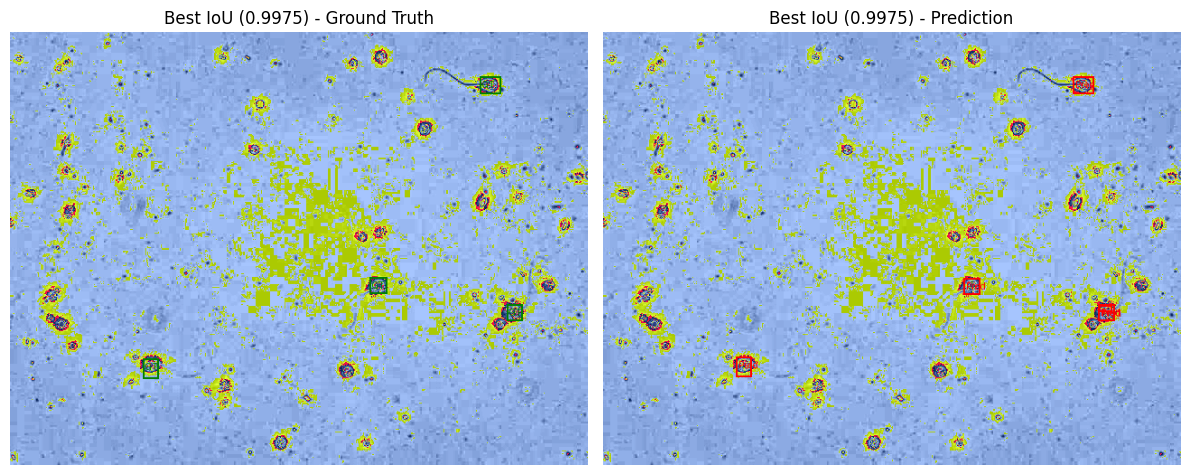

d:\UNCC Grad\Spring 2025\DSBA 6165\Project\Rape-kit-sperm-analysis\.venv\lib\site-packages\torchvision\utils.py:215: UserWarning: boxes doesn't contain any box. No box was drawn
  warnings.warn("boxes doesn't contain any box. No box was drawn")


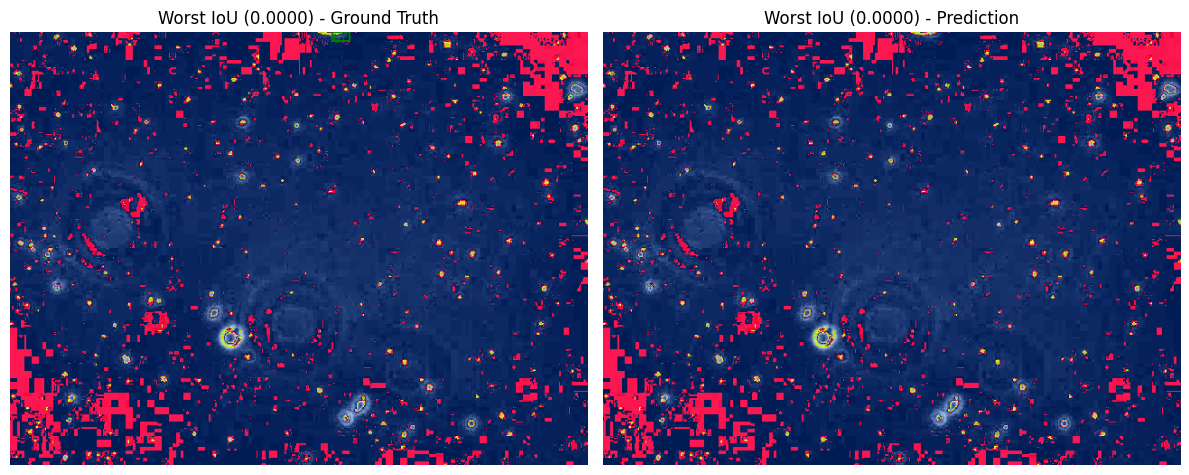

In [19]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from torchvision.utils import draw_bounding_boxes
import numpy as np

def calculate_iou_per_image(model, dataloader, device):
    model.eval()
    ious = []
    all_data = []

    with torch.no_grad():
        for images, targets in dataloader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for img, target, output in zip(images, targets, outputs):
                true_boxes = target['boxes'].cpu()
                pred_boxes = output['boxes'].cpu()
                pred_scores = output['scores'].cpu()

                # Filter by score threshold
                pred_boxes = pred_boxes[pred_scores > 0.7]

                # Compute IoU
                if len(true_boxes) == 0 or len(pred_boxes) == 0:
                    iou = 0.0
                else:
                    iou = torchvision.ops.box_iou(true_boxes, pred_boxes).max().item()

                ious.append(iou)
                all_data.append((img.cpu(), true_boxes, pred_boxes))

    return ious, all_data

def plot_gt_and_pred(image, gt_boxes, pred_boxes, title, score_thresh=0.7):
    image_uint8 = (image * 255).byte()
    image_with_gt = draw_bounding_boxes(image_uint8, gt_boxes, colors="green", width=2, labels=["GT"]*len(gt_boxes))
    image_with_pred = draw_bounding_boxes(image_uint8, pred_boxes, colors="red", width=2, labels=["Pred"]*len(pred_boxes))
    
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(F.to_pil_image(image_with_gt))
    axes[0].set_title(f"{title} - Ground Truth")
    axes[0].axis("off")

    axes[1].imshow(F.to_pil_image(image_with_pred))
    axes[1].set_title(f"{title} - Prediction")
    axes[1].axis("off")
    plt.tight_layout()
    plt.show()

# Run the analysis
ious, all_data = calculate_iou_per_image(final_model, val_loader, device)

# Get indices of best and worst
best_idx = np.argmax(ious)
worst_idx = np.argmin(ious)

# Plot best IoU example
best_img, best_gt, best_pred = all_data[best_idx]
plot_gt_and_pred(best_img, best_gt, best_pred, title=f"Best IoU ({ious[best_idx]:.4f})")

# Plot worst IoU example
worst_img, worst_gt, worst_pred = all_data[worst_idx]
plot_gt_and_pred(worst_img, worst_gt, worst_pred, title=f"Worst IoU ({ious[worst_idx]:.4f})")


In [20]:
import pandas as pd

def validate_and_save(model, val_loader, df, device, save_path="validation_results.csv", score_thresh=0.5):
    model.eval()
    results = []

    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, output in enumerate(outputs):
                frame_id = targets[i]['image_id'].item()
                frame_name = val_dataset.image_ids[frame_id]

                scores = output['scores'].cpu()
                pred_count = (scores > score_thresh).sum().item()

                true_count = df[df['frame_name'] == frame_name]['sperm_count'].iloc[0]
                abs_error = abs(true_count - pred_count)

                results.append({
                    "frame_name": frame_name,
                    "true_count": true_count,
                    "predicted_count": pred_count,
                    "abs_error": abs_error
                })

    # Convert to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(save_path, index=False)

    print(f"✅ Saved validation results to {save_path}")

    # Optional: Print average error
    mean_abs_error = results_df["abs_error"].mean()
    print(f"🔍 Mean Absolute Count Error: {mean_abs_error:.2f}")

    return results_df


Image 1 — Predicted sperm count: 3


TypeError: Invalid shape (3, 480, 640) for image data

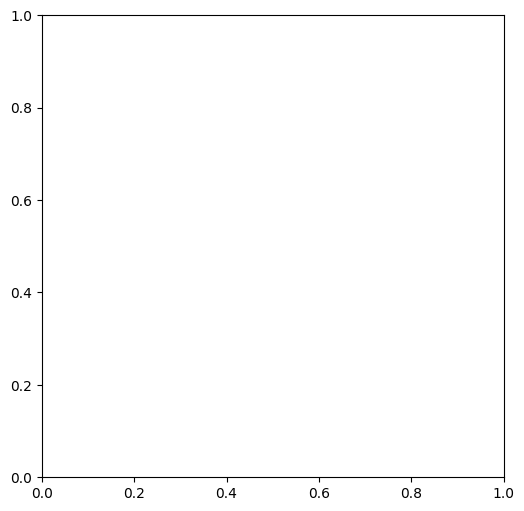

In [22]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set model to evaluation mode
final_model.eval()

# Disable gradient computation for faster inference
with torch.no_grad():
    for i, (images, targets) in enumerate(val_loader):
        images = [img.to(device) for img in images]

        # Get predictions
        outputs = final_model(images)

        for img_idx in range(len(images)):
            boxes = outputs[img_idx]['boxes']
            scores = outputs[img_idx]['scores']

            # Filter boxes with confidence score > threshold
            score_thresh = 0.5
            keep = scores > score_thresh
            boxes = boxes[keep].cpu().numpy()
            scores = scores[keep].cpu().numpy()

            sperm_count = len(boxes)
            print(f"Image {i * len(images) + img_idx + 1} — Predicted sperm count: {sperm_count}")

            # Optional: Visualize predictions for the first few images
            if i < 3:  # show only the first few batches
                img = images[img_idx].cpu().squeeze().numpy()  # [1, H, W] → [H, W]
                fig, ax = plt.subplots(1, 1, figsize=(8, 6))
                ax.imshow(img, cmap='gray')
                for box in boxes:
                    xmin, ymin, xmax, ymax = box
                    rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                             linewidth=1.5, edgecolor='lime', facecolor='none')
                    ax.add_patch(rect)
                ax.set_title(f"Predicted Count: {sperm_count}")
                plt.axis("off")
                plt.show()


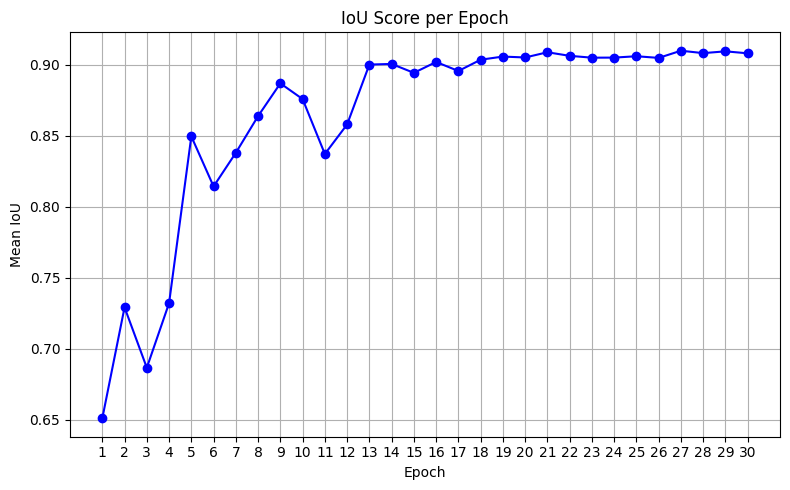

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), iou_per_epoch, marker='o', color='blue')
plt.title("IoU Score per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Mean IoU")
plt.grid(True)
plt.xticks(range(1, num_epochs + 1))
plt.tight_layout()
plt.show()

In [ ]:
# # Save the trained model weights
# save_path = "fasterrcnn_resnet152_sperm.pth"
# torch.save(model.state_dict(), save_path)

# # Optionally save optimizer state too
# # torch.save({
# #     'model_state_dict': model.state_dict(),
# #     'optimizer_state_dict': optimizer.state_dict()
# # }, save_path)


In [ ]:
# # Rebuild the model architecture
# backbone = resnet152(pretrained=True)
# backbone = nn.Sequential(*list(backbone.children())[:-2])
# backbone.out_channels = 2048

# anchor_generator = AnchorGenerator(
#     sizes=((16, 32, 64, 128, 256),),
#     aspect_ratios=((0.5, 1.0, 2.0),) * 5
# )

# roi_pooler = torchvision.ops.MultiScaleRoIAlign(
#     featmap_names=['0'], output_size=7, sampling_ratio=2
# )

# model = FasterRCNN(
#     backbone,
#     num_classes=2,  # sperm + background
#     rpn_anchor_generator=anchor_generator,
#     box_roi_pool=roi_pooler
# )

# # Load weights
# model.load_state_dict(torch.load("fasterrcnn_resnet152_sperm.pth"))
# model.to(device)
# model.eval()  # set to evaluation mode
